
# ***Previsão de vendas***

*DS: Carlos Silva, WIMyD*

----


# 🎯 Alvo
Montar a previsão de como as vendas se comportarão no próximo mês para gerenciar estoque e fazer estimativa de receita.
___________



# 💭Proposta
___
1. Coleta e preparação dos dados (ETL):
    - Coletar tabela fonte de dados.
    - Transformar os dados em em série temporal.
    - Verificar a qualidade dos dados, procurando por lacunas, dados faltantes ou outliers.
    - Realizar pré-processamento, como preenchimento de dados faltantes ou remoção de outliers.
___
2. Análise exploratória de dados (EDA):
    - Vizualizar a série temporal para entender sua estrutura e padrões.
    - Calcular estatísticas descritivas, como média, mediana, desvio padrão, etc.
    - Identificar tendências, sazonalidades ou padrões cíclicos presentes nos dados.
    - Verificar a presença de autocorrelação, ou seja, se os valores passados influenciam os futuros.
___
3. Decomposição da série temporal:
    - Separar a série temporal em componentes distintos, como tendência, sazonalidade e componente de erro.
    - Utilizar métodos como a decomposição aditiva (quando os componentes são somados) ou multiplicativa (quando são multiplicados).
___
4. Modelagem:
    - Dividir os dados em conjunto de treinamento e conjunto de teste, reservando uma parte dos dados para avaliação posterior do desempenho do modelo.
    - Parametrizar o modelo Prophet.
    - Capturar de dados e testes de modelagem usando MLFlow  (MLOps dos modelos).
    - Validar o modelo usando os dados de teste, calculando métricas de desempenho como erro médio absoluto (MAE), erro médio quadrático (RMSE) ou coeficiente de determinação (R²). Considerar validação cruzada.
___ 
5. Avaliação e refinamento:
    - Avaliar o desempenho do modelo de previsão com base nas métricas escolhidas.
    - Se necessário, otimização de hiperparâmetros.
    - Repita os passos anteriores, se necessário, até obter um modelo adequado.
___
6. Previsão:
    - Utilize o modelo ajustado para fazer previsões futuras da série temporal.
    - Avalie a precisão das previsões comparando-as com os valores reais observados, se disponíveis.
___
7. Deploy:
    - Salvar modelo em produção e documentar em API

# 🖥️Ambiente
Nesse projeto optei por usar a distro WSL do Ubuntu a conectando com o VSCode.\
Dentro do terminal WSL é importante seguir com esses comandos para preparar o ambiente

>```bash
>cd /
>git clone https://github.com/Padawanh/ForecastSales
>git config --global user.email "seuemail@example.com"
>git config --global user.name "Seu Nome"
>sudo apt-get update
>sudo apt-get install python3-pip
>pip install -r /ForecastSales/requiriments.txt
>```
>

# 📚 Imports

In [1]:
# Pacotes para processamento de dados
import pandas as pd
import numpy as np

#Pacotes para vizualisação de dados
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

#Pacotes para decomposição da série temporal
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# Pacotes para MLOps
import mlflow
from pathlib import Path
from mlflow import MlflowClient
import mlflow.prophet


# Pacotes para modelagem
from prophet import Prophet, serialize
from prophet.diagnostics import cross_validation,performance_metrics
from prophet.plot import plot_cross_validation_metric
import itertools
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Pacotes para verificar a API
import requests
import json

# 💽 Dataset

In [2]:
orders = pd.read_csv("../data/raw/orders_dataset_raw.csv",
                        #nrows=100,
                        dtype={'order_item_id': str},sep=",",
                        parse_dates = ['order_approved_at'],usecols=['order_id','order_approved_at']
                        )              
orders.info(show_counts=True)
display(orders.head())
print(orders.isnull().sum())
#Teste

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   order_id           99441 non-null  object        
 1   order_approved_at  99281 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 1.5+ MB


order_id   order_approved_at
0  e481f51cbdc54678b7cc49136f2d6af7 2017-10-02 11:07:15
1  53cdb2fc8bc7dce0b6741e2150273451 2018-07-26 03:24:27
2  47770eb9100c2d0c44946d9cf07ec65d 2018-08-08 08:55:23
3  949d5b44dbf5de918fe9c16f97b45f8a 2017-11-18 19:45:59
4  ad21c59c0840e6cb83a9ceb5573f8159 2018-02-13 22:20:29

order_id               0
order_approved_at    160
dtype: int64


# ⚙️ ETL


In [3]:
def AgregateDf(df,columns,DateCol,setDateName="ds"):
    #Existem várias ordens de compra executadas por dia, essa função calcula o total diário.
    df = df[columns].copy()
    
    df[DateCol] = pd.to_datetime(df[DateCol]).dt.date
    df = df.groupby(DateCol,as_index=False).count()
    df.columns = [ setDateName,"count"]
    df[setDateName] = pd.to_datetime(df[setDateName]).dt.date
    return df.sort_values(setDateName)

def CleanDiffDaysGap(df,DateCol='ds',gap=7):
    #Estou identificando pontos na série buracos na série maiores que 7 dias e eliminando intervalos anteriores a isso
    df['diferenca_dias'] = df[DateCol].diff().dt.days
    StartSiseDf = len(df)
    StartSliceClean= df[df['diferenca_dias']>gap]['ds'].max()
    df = df[df['ds']>=StartSliceClean].copy()
    FinishSiseDf = len(df)
    ChangeCut = 1-(FinishSiseDf/StartSiseDf)
    print(f"O dataset diminuiu em {ChangeCut:.0%}")
    df.drop(columns='diferenca_dias',inplace=True)
    return df

def InterpolateSerie (df,DateCol='ds',InterpolateCol = 'count', order = 7):
    #Interpolo a série em até 7 dias
    df = df.copy()
    df.set_index(DateCol,inplace=True)
    df =df.asfreq('D')
    df[InterpolateCol] = df[InterpolateCol].interpolate(method='linear', order=order)
    return df



orders.dropna(subset=['order_approved_at'],inplace=True)    
orders_daily = AgregateDf(orders,['order_id','order_approved_at'],'order_approved_at')
orders_daily = CleanDiffDaysGap(orders_daily,DateCol='ds')
orders_daily = InterpolateSerie(orders_daily,DateCol='ds')
orders_daily.columns=['Qt_Pedidos']
orders_daily.to_csv("../data/processed/process01_daily_orders_clean.csv") #Dados parciais salvos
orders_daily

O dataset diminuiu em 2%


Qt_Pedidos
ds                    
2017-01-05         3.0
2017-01-06         3.0
2017-01-07        33.0
2017-01-08         4.0
2017-01-09         4.0
...                ...
2018-08-30        12.2
2018-08-31         9.4
2018-09-01         6.6
2018-09-02         3.8
2018-09-03         1.0

[607 rows x 1 columns]

# 📊EDA

## 📈 Série temporal de vendas

Os dados parecem irregulares com uma quebra no padrão sazonal semanal depois '2018-08-25, o padrão é os pedidos ficarem dentro da semana em uma queda de 5 dias e depois uma alta abrupta. Depois dessa data os pedidos entram em um queda de mais de 10 dias. Por conta disso decidi extrair eles da modelagem por conta da possibilidade de dados incompletos. Nesse caso é interessante ver com o cliente e auditar a base de dados.

In [4]:
px.line(orders_daily,
        y='Qt_Pedidos',
        #x='date',
        title="Série temporal de vendas",
        labels={"ds": "Data", "Qt_Pedidos": "Quantidade de Pedidos"}
        ).show()

In [5]:
fig = px.line(orders_daily.loc['2018-07-01':],
        y='Qt_Pedidos',
        #x='date',
        title="Série temporal de vendas - Últimos 17 dias e marcações de sazonalidade de queda semanal",
        labels={"ds": "Data", "Qt_Pedidos": "Quantidade de Pedidos"}
        )

fig.add_vline(x='2018-08-07')
fig.add_vline(x='2018-08-12')

fig.add_vline(x='2018-08-20')
fig.add_annotation(x='2018-08-20', y=444, text="Alta     ")

fig.add_vline(x='2018-08-25')
fig.add_annotation(x='2018-08-25', y=81, text="Baixa     ")


fig.add_annotation(x='2018-08-30', y=15, text="Zona de queda")

fig.show()

In [6]:
orders_daily = orders_daily.loc[:'2018-08-25']
orders_daily

Qt_Pedidos
ds                    
2017-01-05         3.0
2017-01-06         3.0
2017-01-07        33.0
2017-01-08         4.0
2017-01-09         4.0
...                ...
2018-08-21       292.0
2018-08-22       183.0
2018-08-23       146.0
2018-08-24       138.0
2018-08-25        81.0

[598 rows x 1 columns]

## Engenharia de variáveis

Adicionando dados temporais

In [7]:
orders_eda=orders_daily.copy()
orders_eda.reset_index(inplace=True)
orders_eda['Day_Week'] = orders_eda['ds'].dt.weekday
orders_eda['Day_Month'] = orders_eda['ds'].dt.day
orders_eda['Day_Year'] = orders_eda['ds'].dt.dayofyear
orders_eda['Week'] = orders_eda['ds'].dt.isocalendar().week 
orders_eda['Month'] = orders_eda['ds'].dt.month
orders_eda['Quarter'] = orders_eda['ds'].dt.quarter
orders_eda['Year'] = orders_eda['ds'].dt.year
orders_eda.sort_values('ds', axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last', ignore_index=False, key=None)
orders_eda['Mes_ano'] = orders_eda['ds'].to_numpy().astype('datetime64[M]')

## Informações gerais
Ficou evidênciado uma marcação semanal principalmente na Terça, com valores médios altos e domingo com valores médios baixos.
Na terça os valores são elevados porém os mais dispersos, o segundo maior é  quarta porém menos disperso que terça.
Domingo além das média menores também é menos disperso.

/tmp/ipykernel_633/1637863401.py:14: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



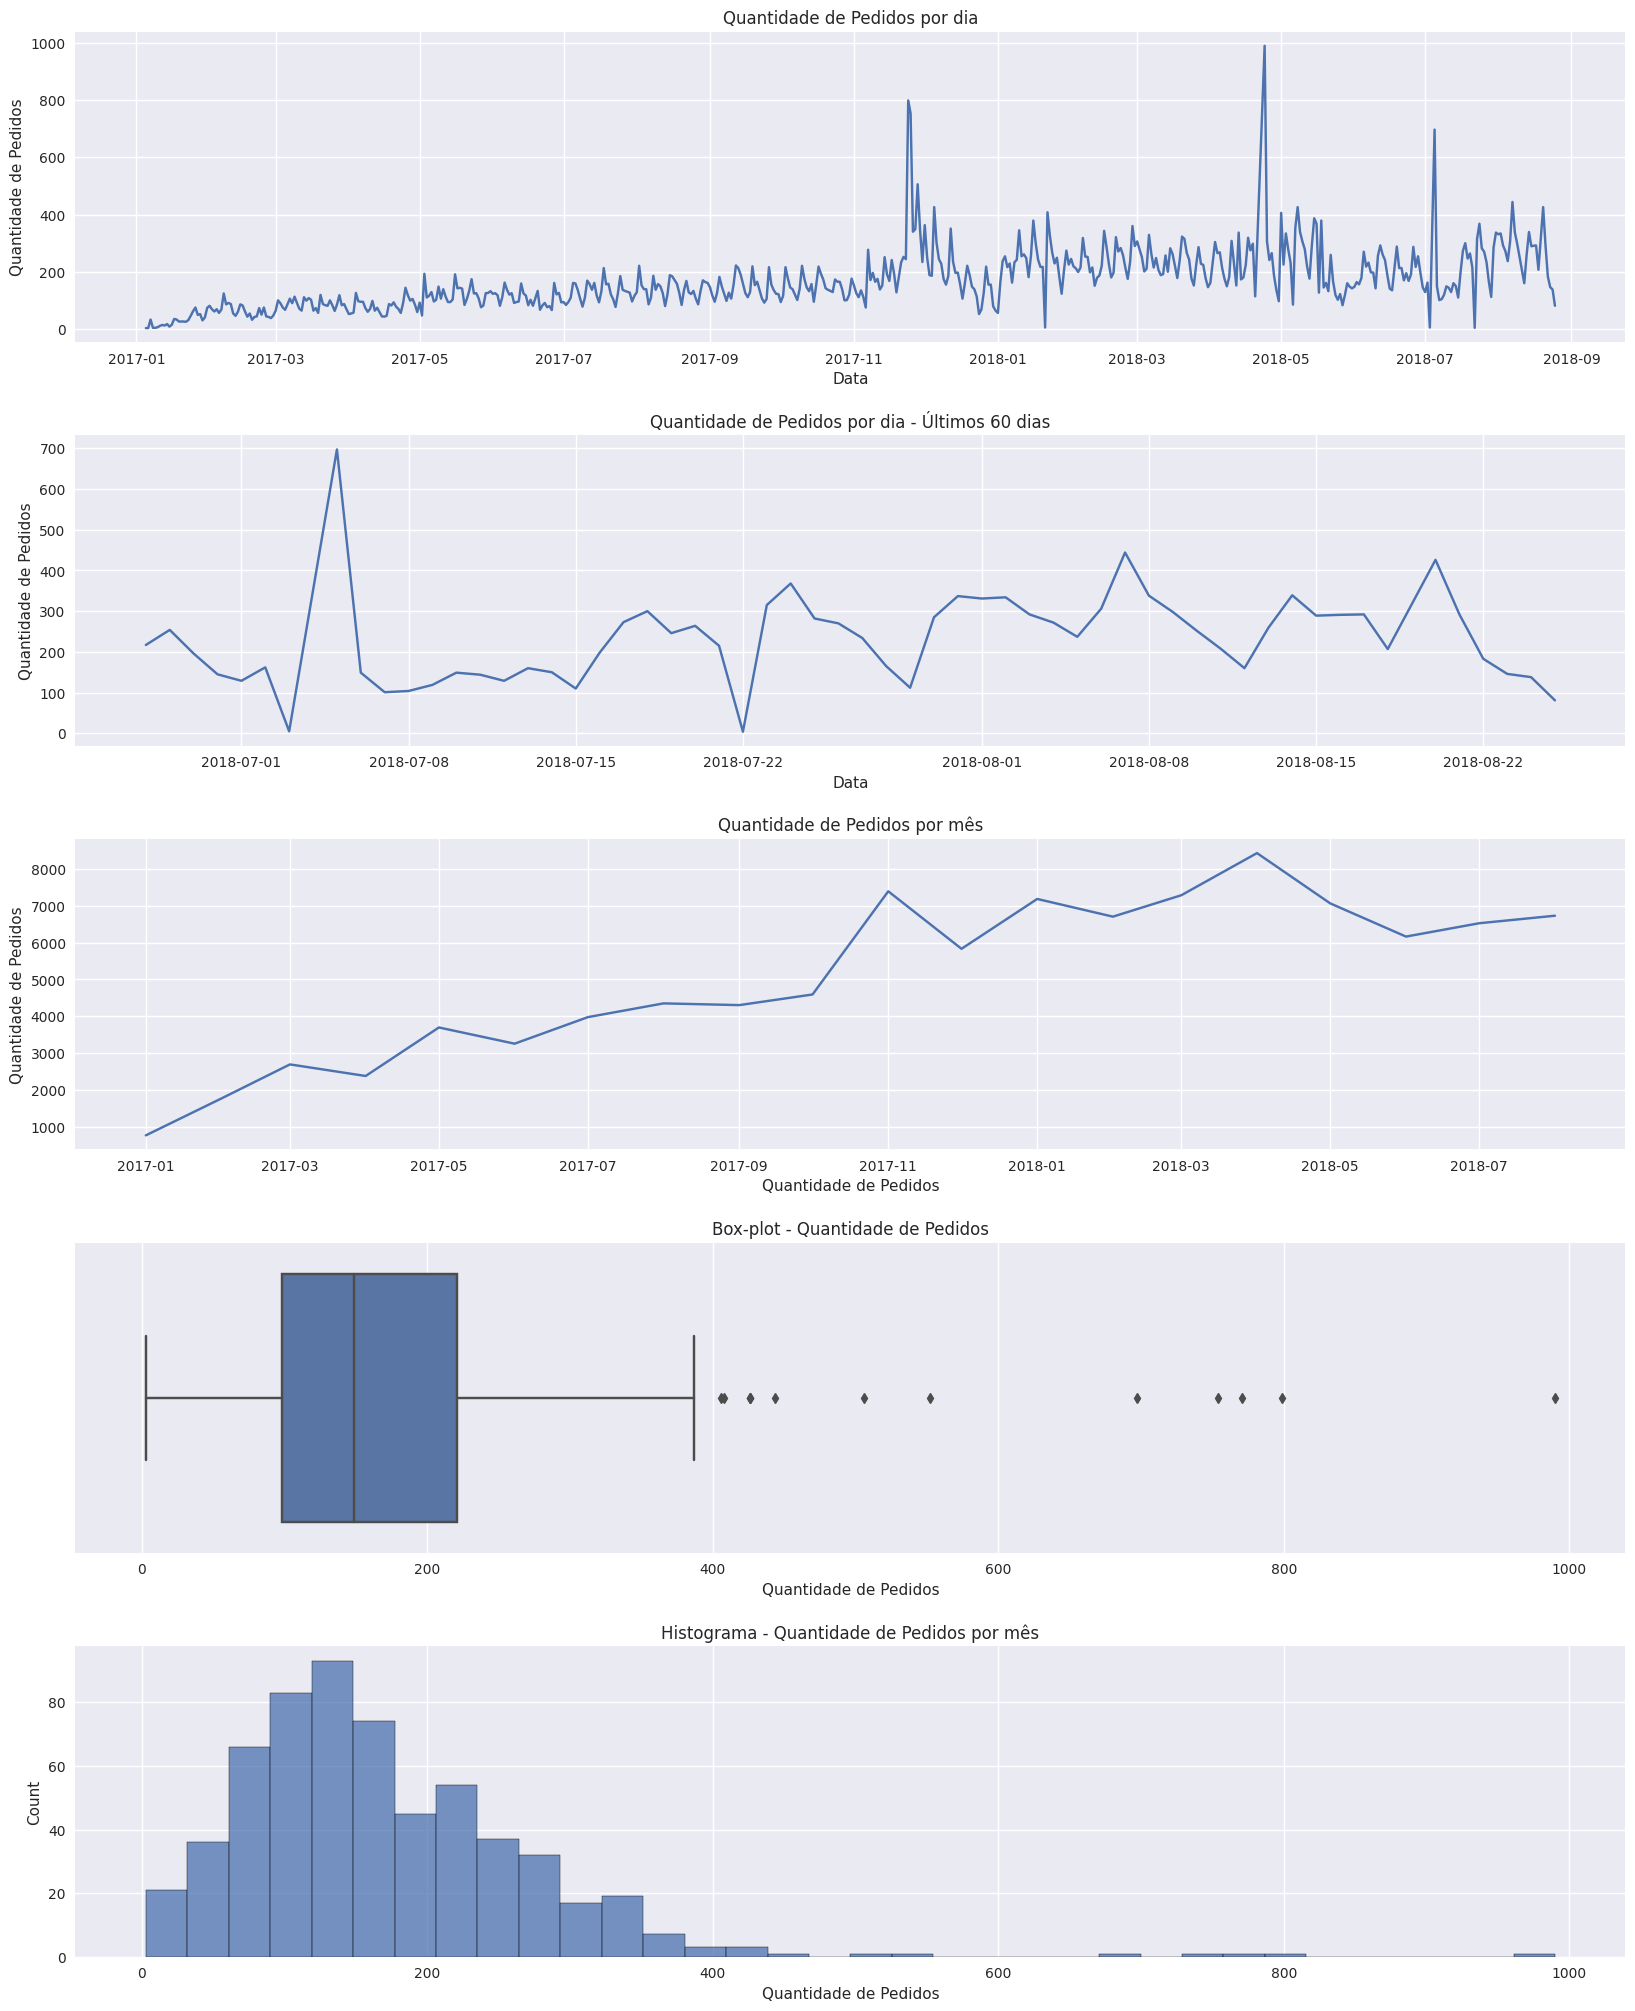

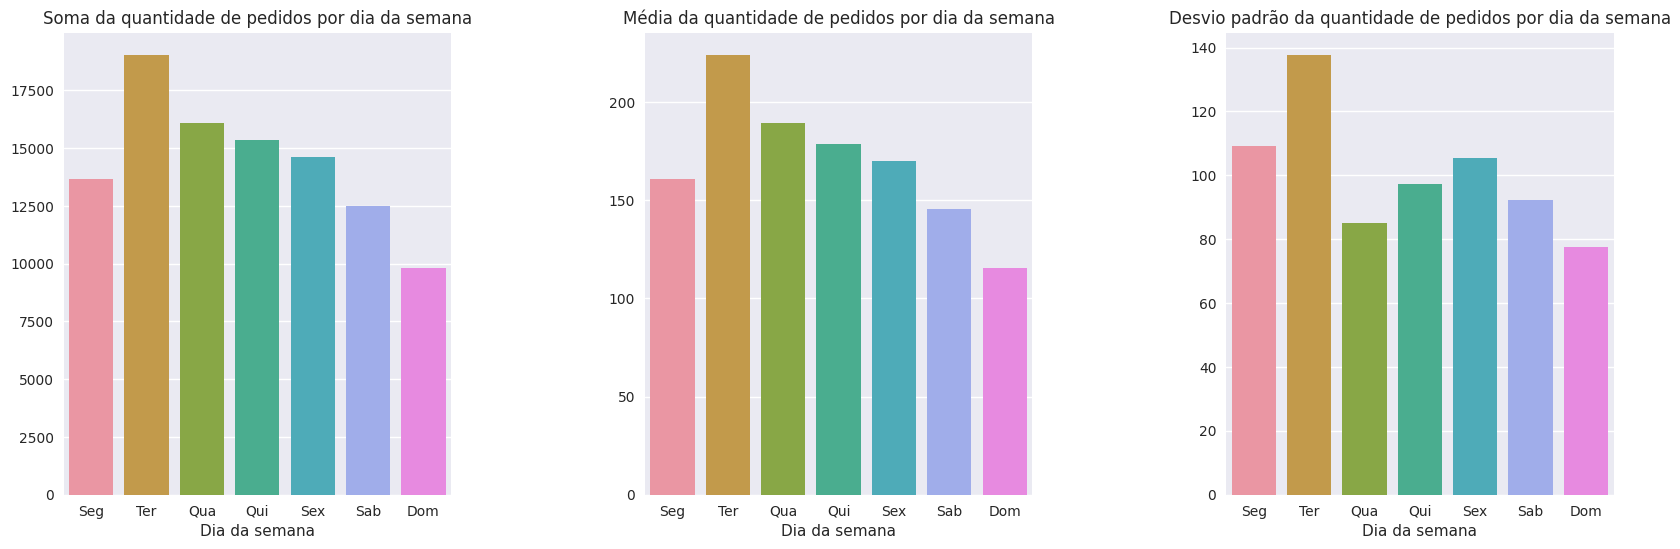

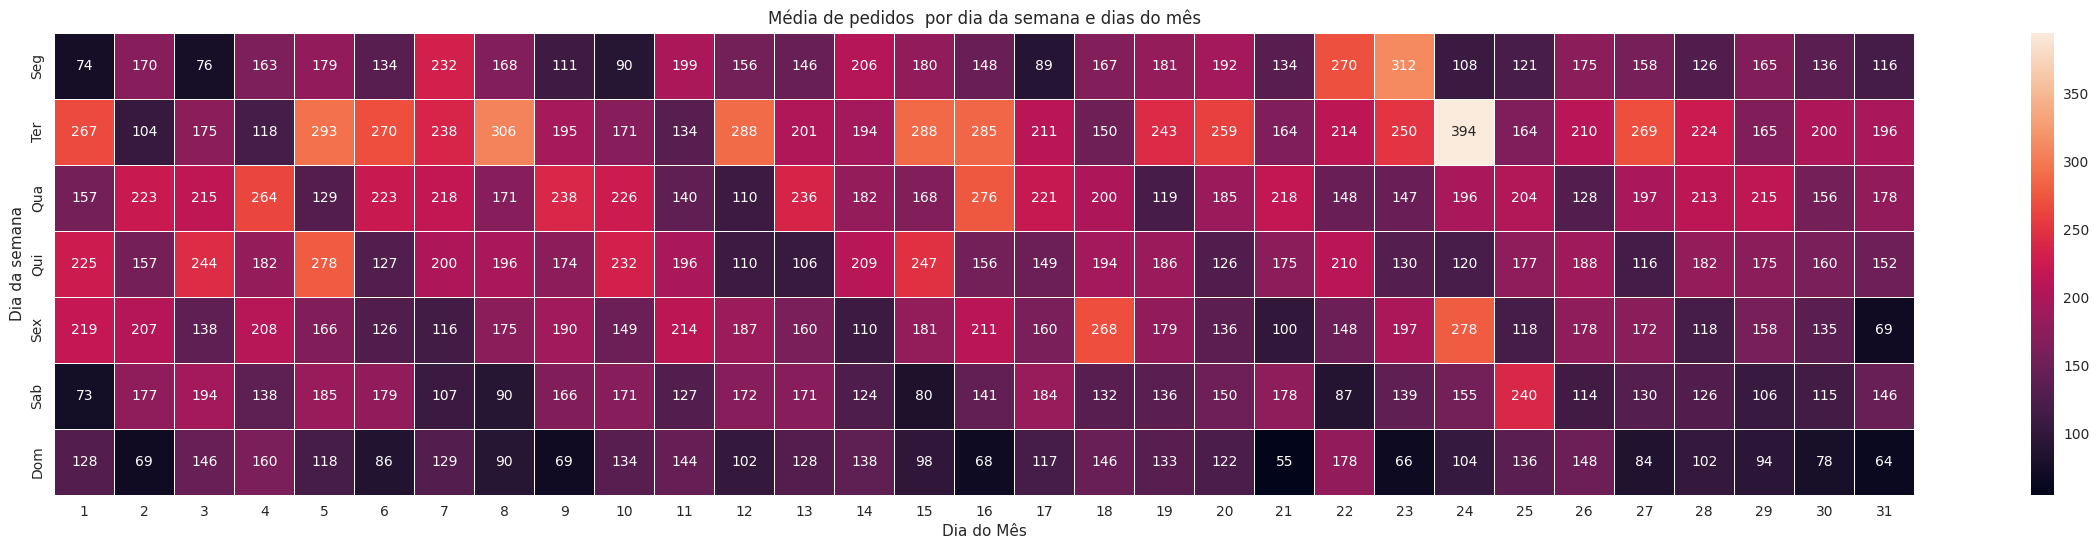

In [8]:
venda_serie_mes = orders_eda[['Mes_ano','Qt_Pedidos']].groupby(['Mes_ano'],as_index=True).sum()

Day_Week_Decribe = orders_eda[["Day_Week","Qt_Pedidos"]].groupby("Day_Week",as_index=False).agg({"Qt_Pedidos":['sum', 'mean','std']})
Day_Week_Decribe.columns = ['Day_Week','quant_ped_sum', 'quant_ped_mean','quant_ped_std']
Day_Week_Decribe['Day_Week'] = ['Seg','Ter','Qua','Qui','Sex','Sab','Dom']

Week_x_Month	 = pd.pivot_table(orders_eda, values='Qt_Pedidos', index=['Day_Week'],
                    columns=['Day_Month'], aggfunc=np.mean)
Week_x_Month.index = ['Seg','Ter','Qua','Qui','Sex','Sab','Dom']


############################# Grágicos #################################################
# plt.style.use('fivethirtyeight')
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 10})

fig, axs = plt.subplots(5,figsize=(20, 25))

sns.lineplot(data=orders_daily["Qt_Pedidos"],ax=axs[0])
axs[0].set_title('Quantidade de Pedidos por dia')
axs[0].set_xlabel('Data')
axs[0].set_ylabel('Quantidade de Pedidos')

sns.lineplot(data=orders_daily["Qt_Pedidos"][-60:],ax=axs[1])
axs[1].set_title('Quantidade de Pedidos por dia - Últimos 60 dias')
axs[1].set_xlabel('Data')
axs[1].set_ylabel('Quantidade de Pedidos')

sns.lineplot(data=venda_serie_mes["Qt_Pedidos"],ax=axs[2])
axs[2].set_title('Quantidade de Pedidos por mês')
axs[2].set_xlabel('Quantidade de Pedidos')
axs[2].set_ylabel('Quantidade de Pedidos')

sns.boxplot(data=orders_daily,x='Qt_Pedidos',ax=axs[3])
axs[3].set_title('Box-plot - Quantidade de Pedidos')
axs[3].set_xlabel('Quantidade de Pedidos')

sns.histplot(data=orders_daily,x='Qt_Pedidos',ax=axs[4])
axs[4].set_title('Histograma - Quantidade de Pedidos por mês')
axs[4].set_xlabel('Quantidade de Pedidos')
plt.subplots_adjust(hspace=0.3)
plt.show()
#####################################################################################

fig, axs = plt.subplots(1,3,figsize=(20, 6))

sns.barplot(data=Day_Week_Decribe,y="quant_ped_sum",x="Day_Week" ,ax=axs[0])
axs[0].set_title("Soma da quantidade de pedidos por dia da semana")
axs[0].set_xlabel('Dia da semana')
axs[0].set_ylabel('')

sns.barplot(data=Day_Week_Decribe,y="quant_ped_mean",x="Day_Week" ,ax=axs[1])
axs[1].set_title("Média da quantidade de pedidos por dia da semana")
axs[1].set_xlabel('Dia da semana')
axs[1].set_ylabel('')

sns.barplot(data=Day_Week_Decribe,y="quant_ped_std",x="Day_Week" ,ax=axs[2])
axs[2].set_title("Desvio padrão da quantidade de pedidos por dia da semana")
axs[2].set_xlabel('Dia da semana')
axs[2].set_ylabel('')
plt.subplots_adjust(wspace=0.5)
plt.show()

###################################################################################

f, ax = plt.subplots(figsize=(30,6))
sns.heatmap(Week_x_Month,
            annot=True,
            fmt="0.0f",
            linewidths=.5, ax=ax)
ax.set_title("Média de pedidos  por dia da semana e dias do mês")
ax.set_xlabel('Dia do Mês')
ax.set_ylabel('Dia da semana')

plt.show()


## Outliers

Essas datas datas podem ser de eventos específicos como:
* Altas em 24 e 25 de 2017/11, Black Friday de 2017.
* Altas em 23 e 24 de 2018/04, final de semana próximo ao dia das mães, também encontrei itens relacionados a Dia do Frete Grátis.
* Para o pico em 2018-07-05 não encontrei nada específico.

Entender essas datas é importante porque são eventos que impactam os pedidos fora de um padrão que possa ser treinado, logo impactando na precisão do mesmo, mas se categorizarmos e planejarmos esses eventos e adiciona-los como caracteristicas do modelo modemos minimizar esses impactosm contudo esse tipo de refinamento não é o foco no momento.

/tmp/ipykernel_633/2803082342.py:1: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.

/tmp/ipykernel_633/2803082342.py:16: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



Qt_Pedidos
ds                    
2017-11-24       799.0
2017-11-25       754.0
2018-04-23       771.0
2018-04-24       990.0
2018-07-05       697.0

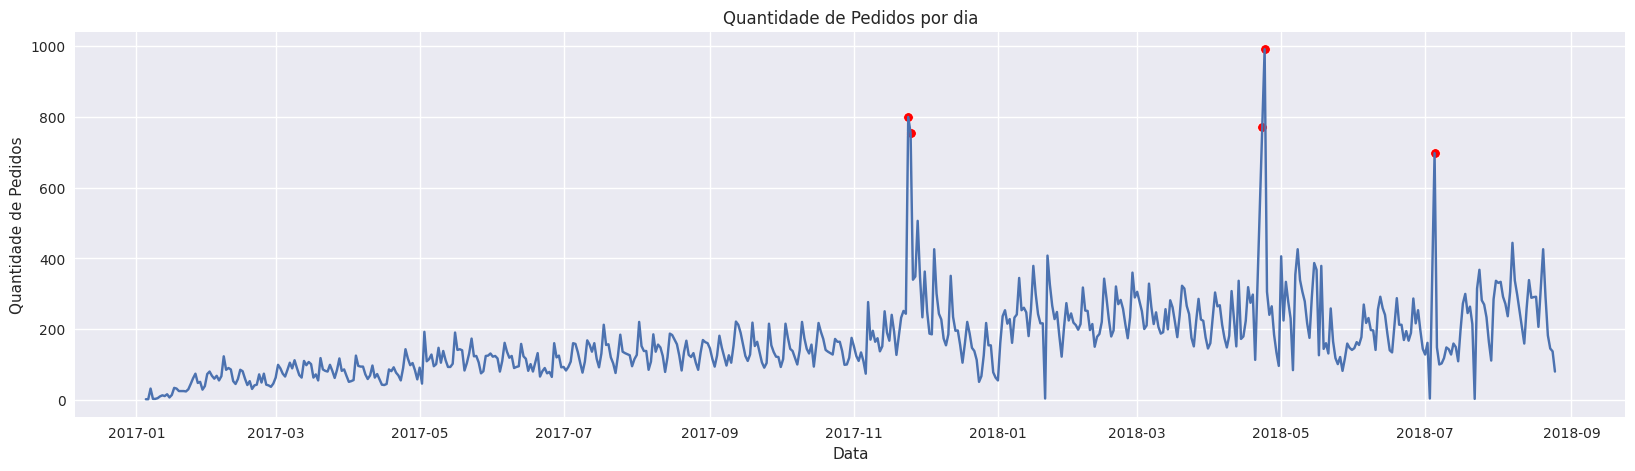

In [9]:
plt.style.use('seaborn')
fig, axs = plt.subplots(1,figsize=(20, 5))

sns.lineplot(data=orders_daily,ax=axs,legend=False,color='green')
sns.scatterplot(y=orders_daily[orders_daily['Qt_Pedidos']>600]["Qt_Pedidos"],
                x=orders_daily[orders_daily['Qt_Pedidos']>600]["Qt_Pedidos"].index,
                ax=axs,
                color="red",
                # size=500,
                legend=False)

axs.set_title('Quantidade de Pedidos por dia')
axs.set_xlabel('Data')
axs.set_ylabel('Quantidade de Pedidos')
# axs.text(x=orders_daily.loc['2017-11-24'].index.values,y=orders_daily.loc['2017-11-24'],s="Texto")
fig.show()
orders_daily[orders_daily['Qt_Pedidos']>600]

## Decomposição

## Testando estacionaridade
Para p < 0,05 é considerado estacionário. No geral a série não atende esse critério em um nível de significância de 5%, mas por bem pouco. Quando fazemos o recorte desse série temporal em duas partes vemos que no mesmo teste a porção mais recente é considereda estacionária, por se tratar do período mais recente vou considerar uma estacionáridade para o futuro dessa série.

In [10]:
print(100*"_")
print(f"Testando estacionaridade geral")

X = orders_daily[['Qt_Pedidos']]
result = adfuller(X)
print('ADF Estatíticas: %f' % result[0])
print('Valor de P: %f' % result[1])
print('Valores Críticos:')
for key, value in result[4].items():
   print('\t%s: %.3f' % (key, value))

n=300 #Corte dos dados

print(100*"_")
print(f"Testando estacionaridade até os {n} primeiros valores")
X = orders_daily[['Qt_Pedidos']][:n]
result = adfuller(X)
print('ADF Estatíticas: %f' % result[0])
print('Valor de P: %f' % result[1])
print('Valores Críticos:')
for key, value in result[4].items():
   print('\t%s: %.3f' % (key, value))

print(100*"_")
print(f"Testando estacionaridade depois dos {n} primeiros valores")


X = orders_daily[['Qt_Pedidos']][n:]
result = adfuller(X)
print('ADF Estatíticas: %f' % result[0])
print('Valor de P: %f' % result[1])
print('Valores Críticos:')
for key, value in result[4].items():
   print('\t%s: %.3f' % (key, value))


____________________________________________________________________________________________________
Testando estacionaridade geral
ADF Estatíticas: -2.752063
Valor de P: 0.065454
Valores Críticos:
	1%: -3.442
	5%: -2.867
	10%: -2.569
____________________________________________________________________________________________________
Testando estacionaridade até os 300 primeiros valores
ADF Estatíticas: -2.376885
Valor de P: 0.148367
Valores Críticos:
	1%: -3.454
	5%: -2.872
	10%: -2.572
____________________________________________________________________________________________________
Testando estacionaridade depois dos 300 primeiros valores
ADF Estatíticas: -4.724102
Valor de P: 0.000076
Valores Críticos:
	1%: -3.453
	5%: -2.872
	10%: -2.572


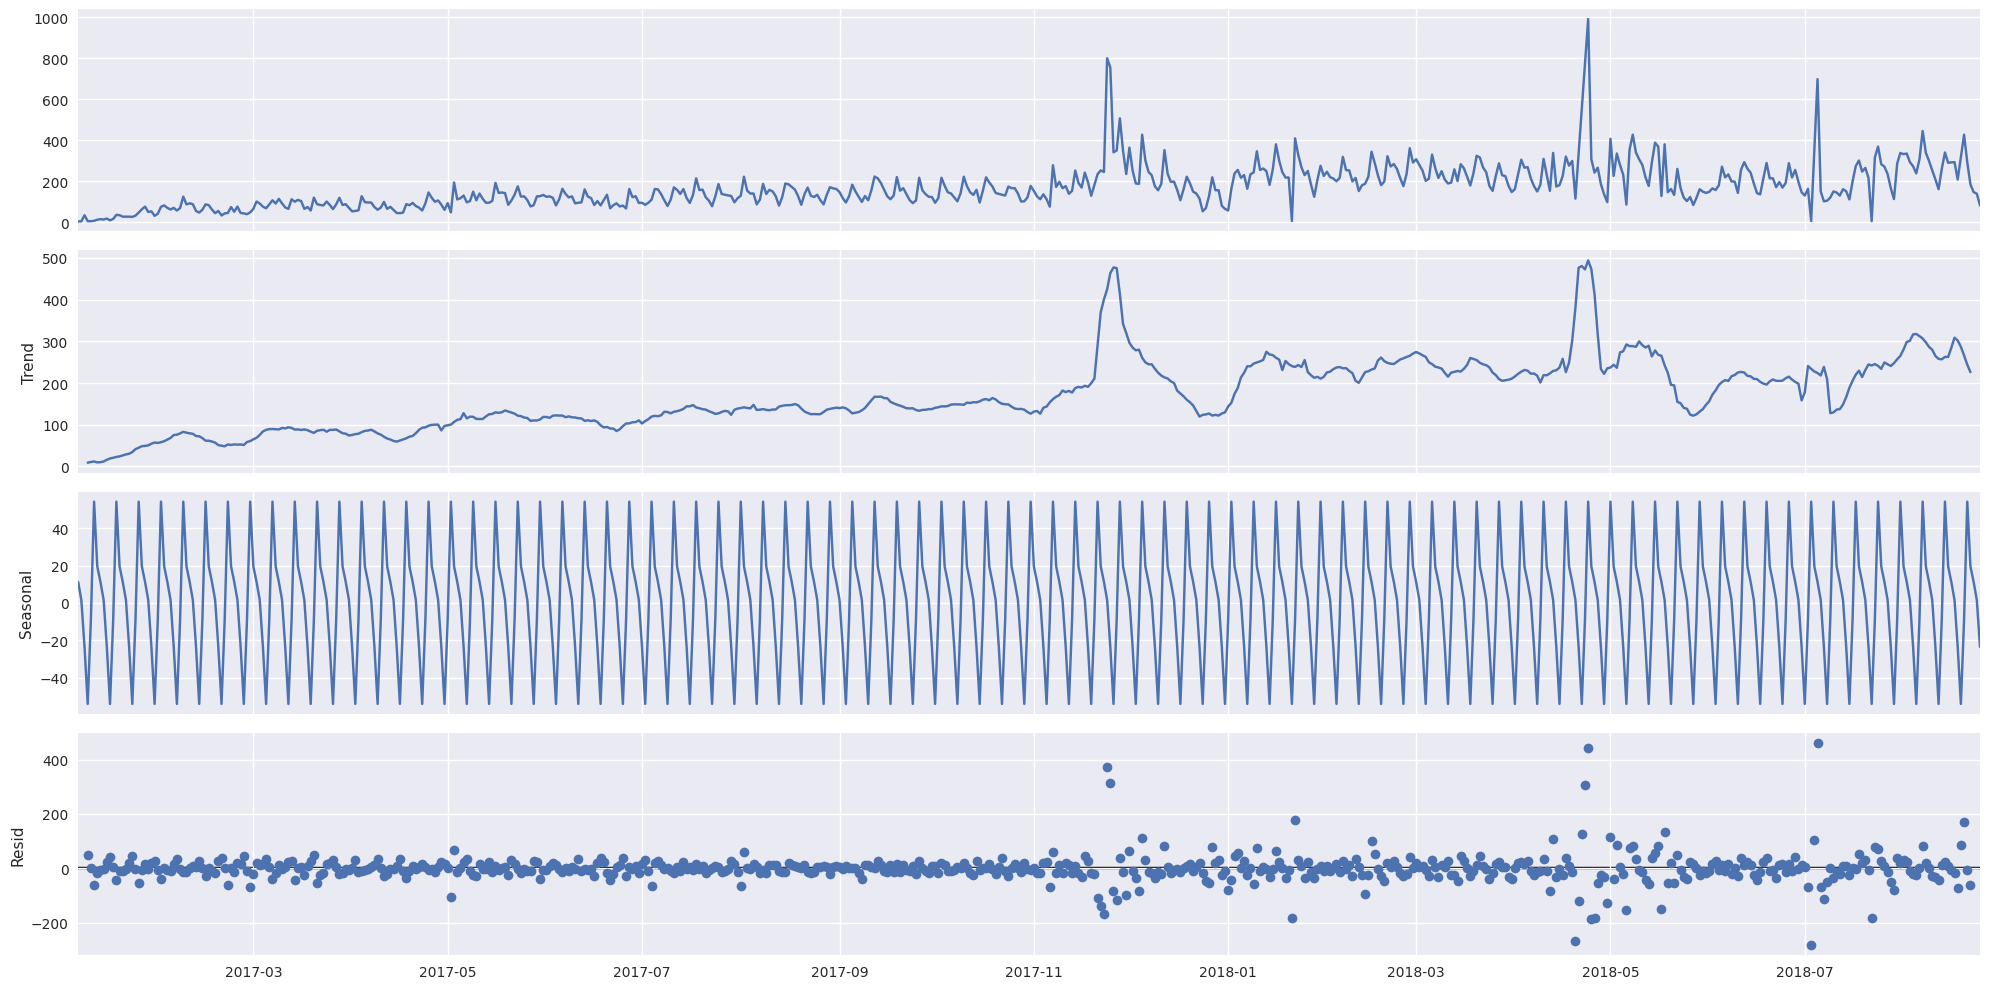

In [11]:

rcParams['figure.figsize'] = 20, 10

# ts_daily.set_index('dia',inplace=True)
decomposition = seasonal_decompose(orders_daily[['Qt_Pedidos']], model='additive')
fig = decomposition.plot()
plt.show()

## Sazonalidade
Aqui se reforça a sazonalidade semanal mostrada anteriormente.

<Axes: title={'center': 'Sazonalidade de 4 semanas'}, xlabel='ds'>

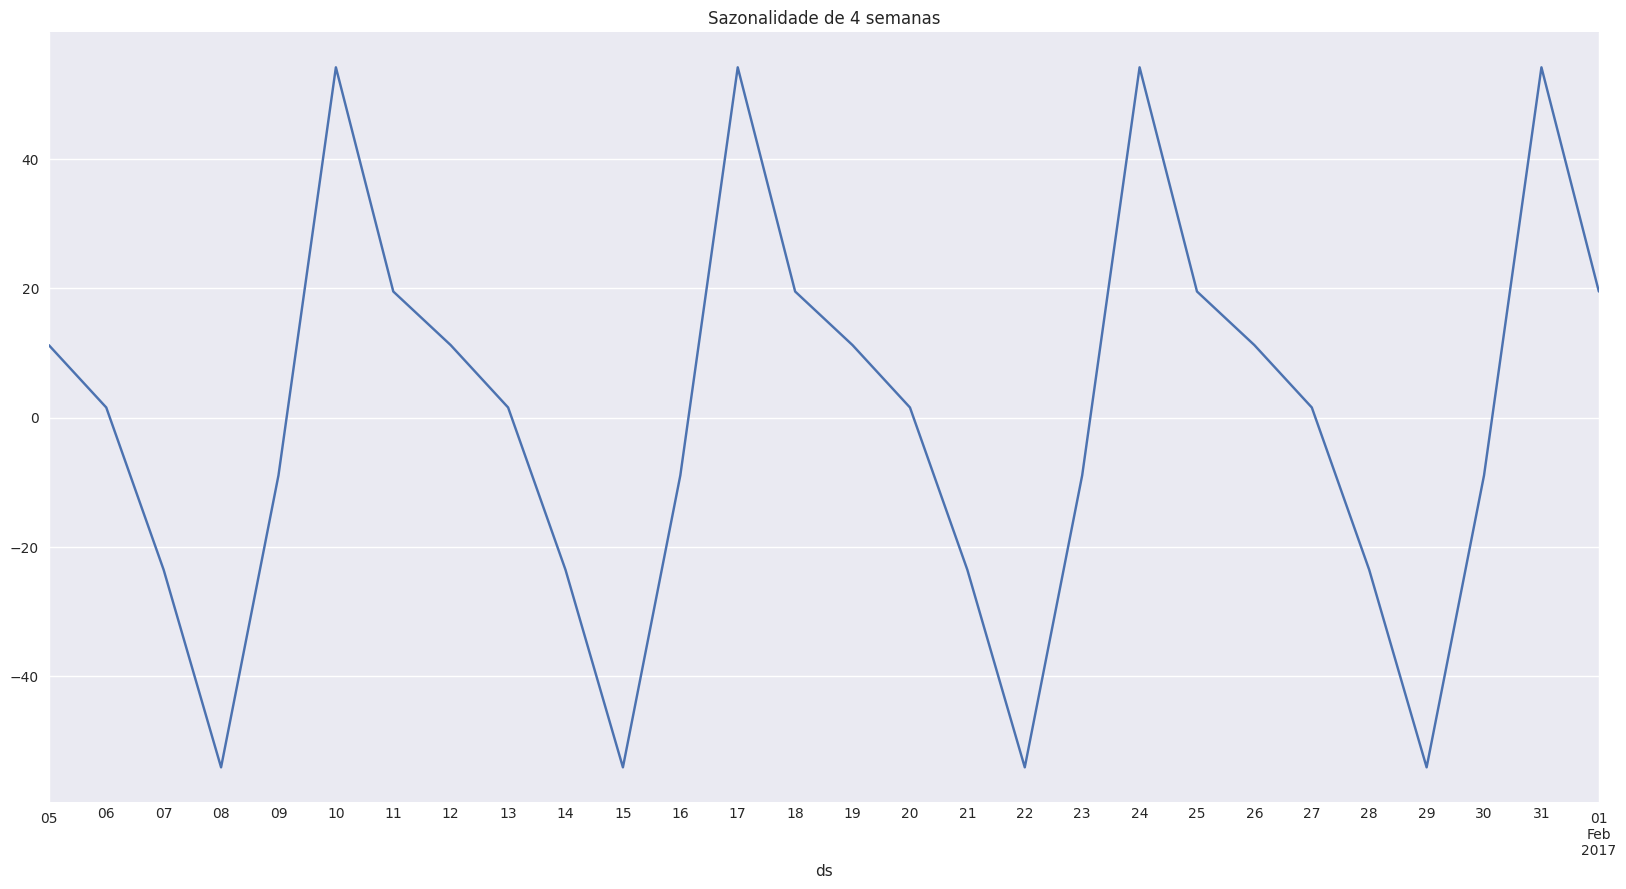

In [12]:
plt.title('Sazonalidade de 4 semanas')
rcParams['figure.figsize'] =  20,3
# fig, axs = plt.subplots(1,figsize=(20, 5))
decomposition.seasonal[:28].plot()

<Axes: title={'center': 'Resíduos de 4 semanas'}, xlabel='ds'>

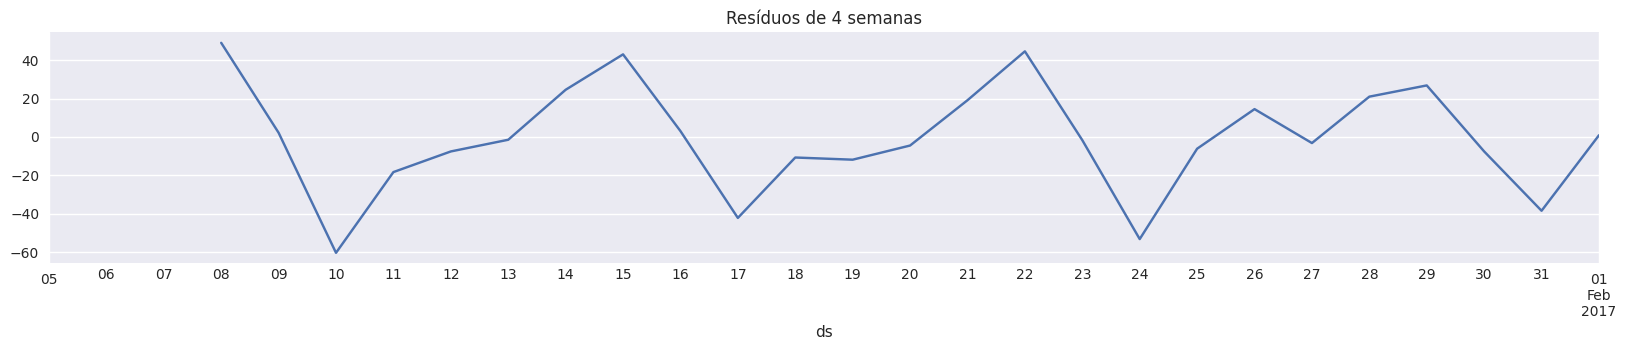

In [13]:
plt.title('Resíduos de 4 semanas')
rcParams['figure.figsize'] = 20,3
decomposition.resid[:28].plot()

## Autocorrelação

A Autocorrelação (ACF) é uma medida estatística que nos ajuda a entender a relação entre os valores de uma série temporal em diferentes momentos no tempo, mede o quanto o momento atual é correlacionado ao conjunto de momentos imediatamente anteriores.

Na nossa série o ela se mostrar superior a 0.5 em até dois dias e em 7 dias, e superior a 0.3 em até duas semanas.


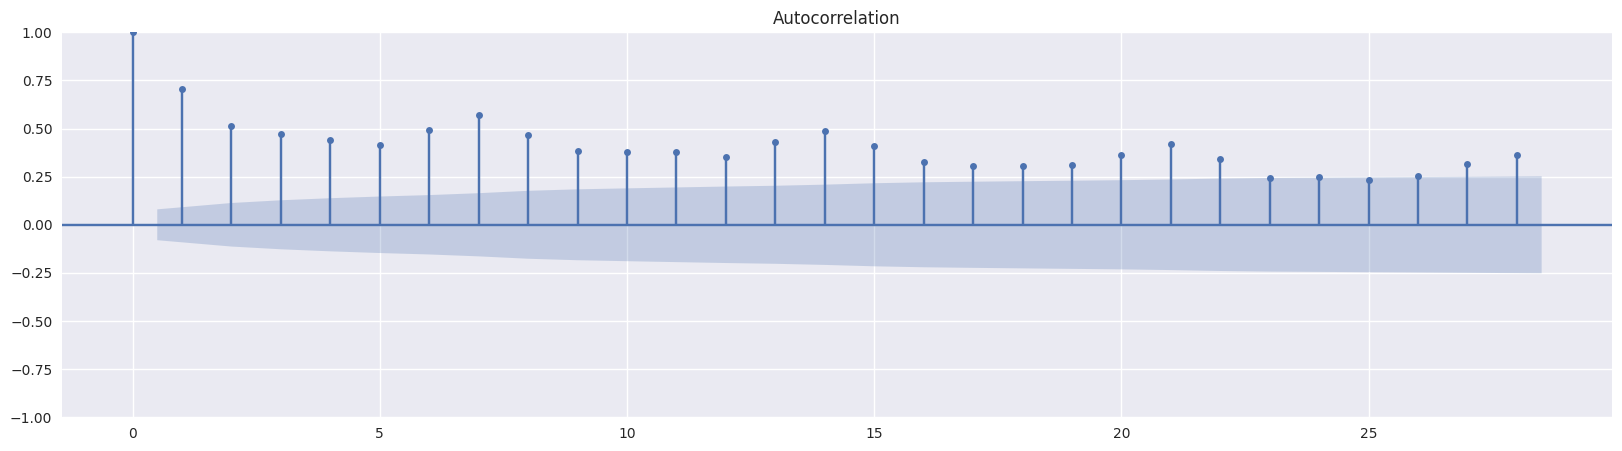

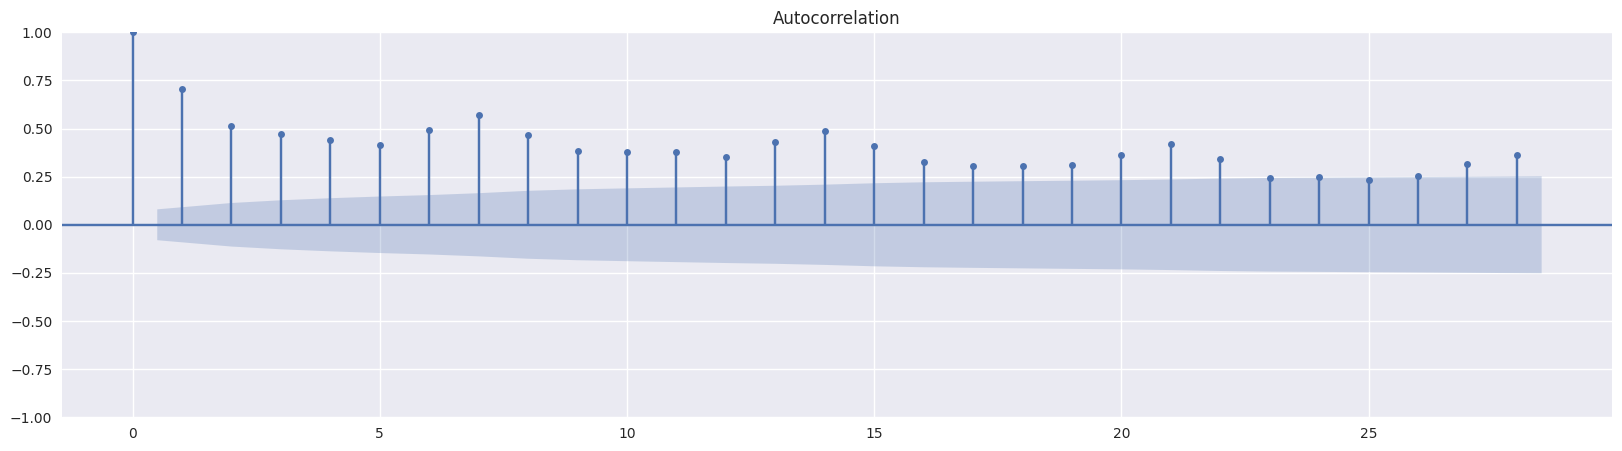

In [14]:
rcParams['figure.figsize'] =  20, 5
plot_acf(orders_daily[['Qt_Pedidos']][:],lags=28)


## Autocorrelação Parcial

A Autocorrelação Parcial (PACF) é uma medida estatística que nos ajuda a entender a relação direta entre duas observações em uma série temporal, removendo a influência das observações intermediárias, isto é, ao contrário da ACF ela não considera o conjunto de itens imediatamente anteriores e sim a relação do momento atual com outro anterior em uma distância especifica.
Na nossa série, com exceção ao dia anterior com quase 0.75 temos os dias 6 e 7 proximos a 0.25, todos os outros são abaixo disso.

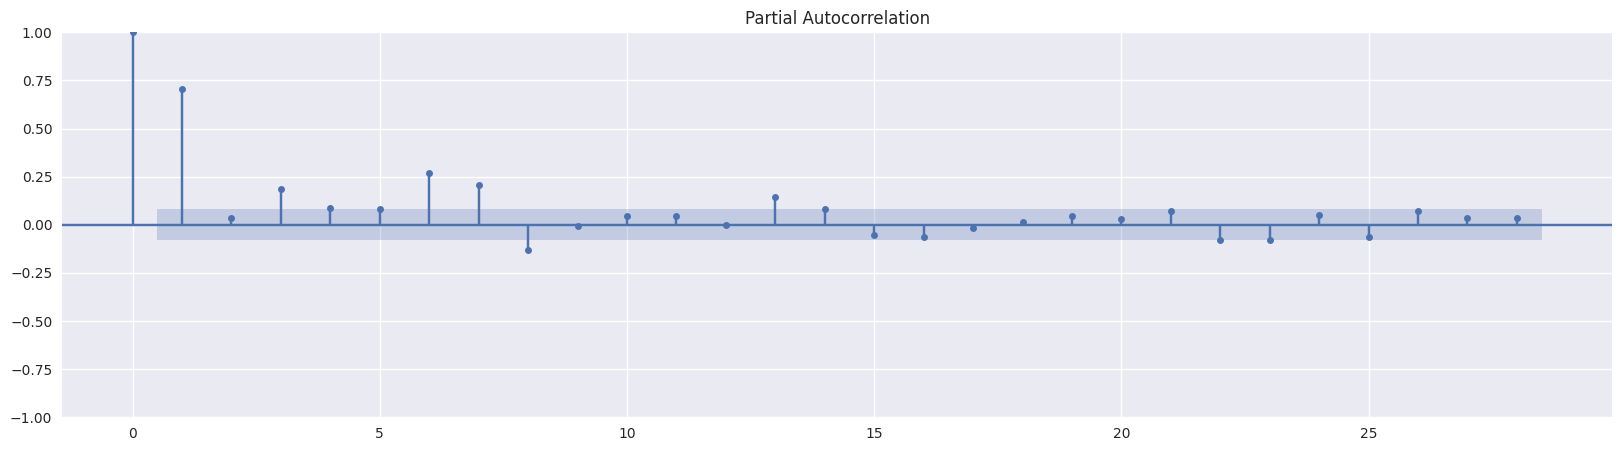

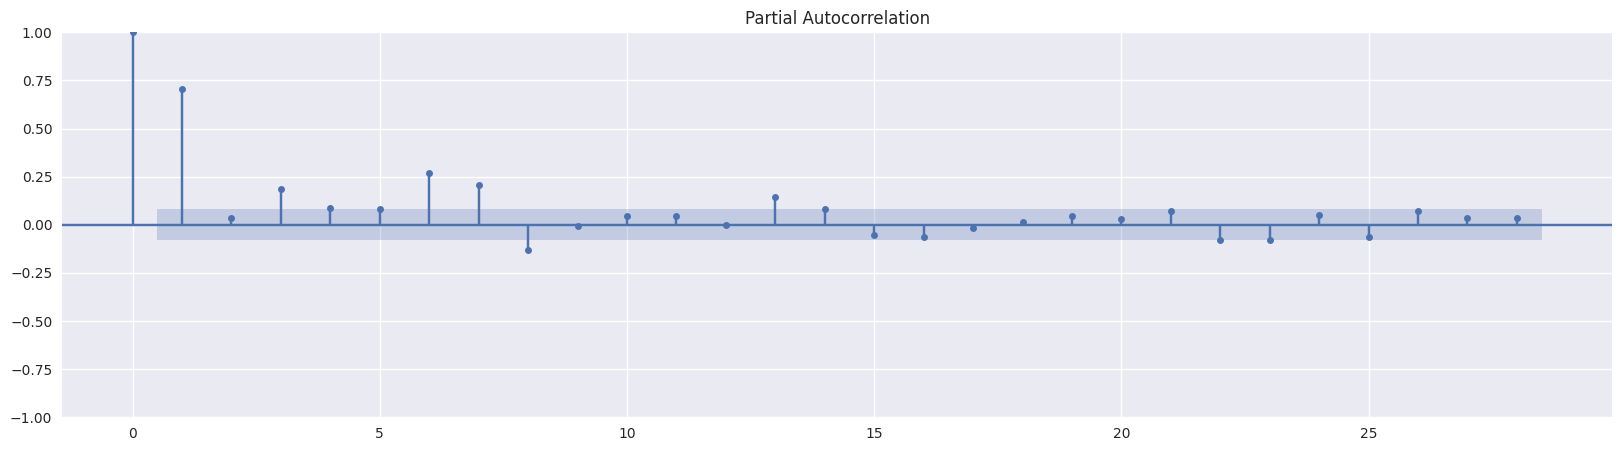

In [15]:
plot_pacf(orders_daily[['Qt_Pedidos']][:],lags=28)

# Treino e teste

In [48]:
len_teste = 30
train = orders_daily[:len(orders_daily)-len_teste]
teste = orders_daily[-len_teste:]


print(f"Treino com {train['Qt_Pedidos'].count()} valores e teste com {teste['Qt_Pedidos'].count()}")


#Alterando para input aceito no Prophet
train_prophet = train['Qt_Pedidos'].reset_index()
train_prophet.columns = ['ds', 'y']

teste_prophet = teste['Qt_Pedidos'].reset_index()
teste_prophet.columns = ['ds', 'y']

Treino com 568 valores e teste com 30


# Modelagem Prophet

Funções

In [27]:


def extract_params(pr_model):
  """Extrai os atributos do modelo Prophet
  Args:
      pr_model (prophet.forecaster.Prophet): Prophet 

  Returns:
      dict: Dicionário com os atributos do modelo
  """
  return {attr: getattr(pr_model, attr) for attr in serialize.SIMPLE_ATTRIBUTES}

def ForecastPlotProphet(df_train,df_predict_raw, df_teste=None, figPath=None,
                        HistorySlice=30, title=None, ShowFigs=True, SaveMLFlow=True):
  """
  Cria as vizualizações de série temporal e salva os artefatos no MLFlow
  
  Args:
      df_train (pandas.DataFrame): tabela de treinamento
      df_predict_raw (pandas.DataFrame): Resultado do 'predict' do Prophet
      df_teste (pandas.DataFrame, optional): tabela de teste. Defaults to None.
      figPath (String, optional): _description_. local para salvar as imagens. Defaults to None.
      HistorySlice (int, optional): Intervalo de corte na vizualização. Defaults to 30.
      title (String, optional): Título do gráfico. Defaults to None.
      ShowFigs (bool, optional): Mostrar figuras. Defaults to True.
      SaveMLFlow (bool, optional): Salvar no MLFlow. Defaults to True.
  """
  df_predict = df_predict_raw[['ds','yhat']].set_index('ds')
  df_predict_plot = df_predict_raw[['ds','yhat','yhat_lower','yhat_upper']].set_index('ds')
  df_predict.columns = ['Previsto']
  rcParams['figure.figsize'] = 30, 5
  # plt.style.use('fivethirtyeight')
  plt.figure()  
  if title is not None:
    plt.title(title)
  plt.plot(df_predict, label='Previsão', color = 'red', linewidth = 2)
  plt.plot(pd.concat([df_train[-HistorySlice:].set_index('ds'), df_predict_plot[['yhat']][:1].rename(columns={"yhat":"y"})]),
    label='Histórico',
    color = 'gray',
    linewidth = 2)
  if df_teste is not None:
    plt.plot(df_teste.set_index('ds'), label='Validação', color = 'blue', linewidth = 2)

  plt.fill_between(df_predict_plot.index,df_predict_plot['yhat_lower'],df_predict_plot['yhat_upper'], alpha=0.5)
  plt.xlabel("Período")
  plt.legend(loc='best')

  if SaveMLFlow:
    if figPath == None:
      figPath =  str(Path(Path.cwd()).parent.joinpath("images").joinpath("Forecast.png"))
    plt.savefig(figPath, dpi=150)
    mlflow.log_artifact(figPath)
    
  if ShowFigs:
    plt.show()
  else:
    plt.close()


In [18]:
train_prophet[30:]

ds      y
30  2017-02-04   69.0
31  2017-02-05   56.0
32  2017-02-06   68.0
33  2017-02-07  124.0
34  2017-02-08   86.0
..         ...    ...
563 2018-07-22    4.0
564 2018-07-23  315.0
565 2018-07-24  368.0
566 2018-07-25  282.0
567 2018-07-26  270.0

[538 rows x 2 columns]

## Modelo Inicial

Antes de prosseguir é importante iniciar qual é o local que vamos salvar nossos modelos, existem muitas formas de fazer isso com o MLFlow, nesse projeto vamos salvar localmente os artefatos e em um SQLite as demais informações, para mais detalhes sobre as formas de funcionamento sugiro acessa a documentação sobre esse assunto [aqui](https://www.mlflow.org/docs/latest/tracking.html#how-runs-and-artifacts-are-recorded).

**MLflow em localhost com SQLite**

<img src="https://www.mlflow.org/docs/latest/_images/scenario_2.png" width="250" height="250">\
Fonte:mlflow.org

No terminal do WLS execute os seguintes comandos, tudo relacionado aos modelos vai ser salvo na pasta 'models'. Isso vai travar o terminal e gerar um link para o UI de gerenciamento do MLFlow.
>```bash
>cd /ForecastSales/models
>mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts --host 0.0.0.0
>```

Além disso é preciso definir o arquivo com as dependências do modelo, vamos precisar disso para fazer o deploy mais tarde.

In [19]:
#dependências do modelo
condaEnv = {"name": "Forecast",
                "channels": ["conda-forge"],
                "dependencies": [ "python=3.7",
                    {"pip": [
                            "pystan",
                            "mlflow",
                            "plotly",
                            "seaborn",
                            "statsmodels",
                            "scikit-learn",
                            "ipywidgets",
                            "prophet"
                        ],
                    },
                ],
            }

### Treino

Sobre os parâmetros
* `seasonality_mode`: Este parâmetro controla se a sazonalidade é aditiva ou multiplicativa.
* `weekly_seasonality`, `daily_seasonality`, `yearly_seasonality`: Esses parâmetros controlam se a sazonalidade semanal, diária e anual deve ser incluída no modelo.
* `changepoint_range`: Este parâmetro controla a proporção da série temporal em que os pontos de mudança são permitidos. O padrão é 0,8, o que significa que os primeiros 80% da série temporal são considerados para possíveis pontos de mudança.
* `changepoint_prior_scale`: Este parâmetro controla a flexibilidade dos pontos de mudança. Valores maiores permitem mudanças mais flexíveis, enquanto valores menores resultam em mudanças mais rígidas.
* `seasonality_prior_scale`: Este parâmetro controla a força da sazonalidade. Valores maiores permitem uma sazonalidade mais forte, enquanto valores menores resultam em uma sazonalidade mais fraca.


17:36:10 - cmdstanpy - INFO - Chain [1] start processing


17:36:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/36 [00:00<?, ?it/s]

17:36:10 - cmdstanpy - INFO - Chain [1] start processing
17:36:10 - cmdstanpy - INFO - Chain [1] done processing
17:36:10 - cmdstanpy - INFO - Chain [1] start processing
17:36:10 - cmdstanpy - INFO - Chain [1] done processing
17:36:10 - cmdstanpy - INFO - Chain [1] start processing
17:36:10 - cmdstanpy - INFO - Chain [1] done processing
17:36:10 - cmdstanpy - INFO - Chain [1] start processing
17:36:10 - cmdstanpy - INFO - Chain [1] done processing
17:36:11 - cmdstanpy - INFO - Chain [1] start processing
17:36:11 - cmdstanpy - INFO - Chain [1] done processing
17:36:11 - cmdstanpy - INFO - Chain [1] start processing
17:36:11 - cmdstanpy - INFO - Chain [1] done processing
17:36:11 - cmdstanpy - INFO - Chain [1] start processing
17:36:11 - cmdstanpy - INFO - Chain [1] done processing
17:36:11 - cmdstanpy - INFO - Chain [1] start processing
17:36:11 - cmdstanpy - INFO - Chain [1] done processing
17:36:11 - cmdstanpy - INFO - Chain [1] start processing
17:36:11 - cmdstanpy - INFO - Chain [1]

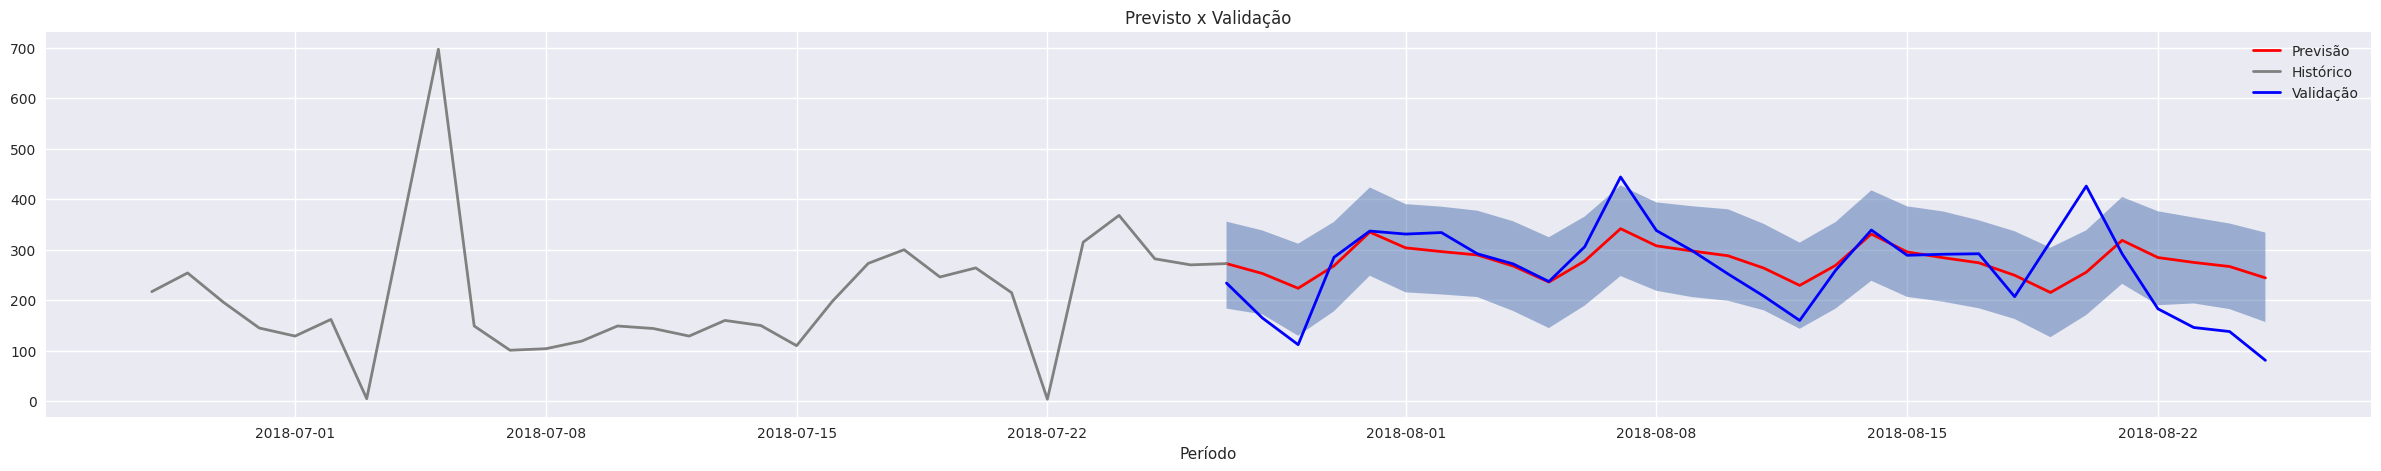

Métrica de Treino com Validação cruzada
{'mse': 7957.729230048133, 'rmse': 86.88550179091966, 'mae': 52.57838733294408, 'mape': 0.6668423327450791, 'mdape': 0.20951834320309, 'smape': 0.28174499549914134, 'coverage': 0.5546153846153846}


<Figure size 3000x500 with 0 Axes>

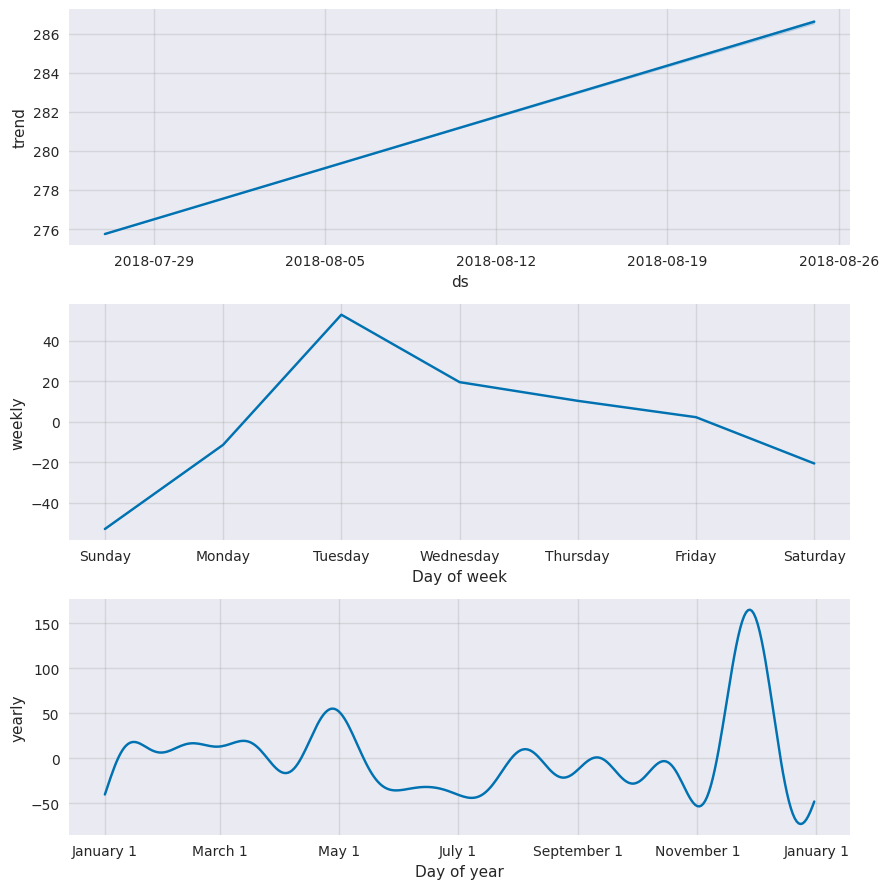

In [52]:

prophet_model = Prophet(seasonality_mode='additive',
            weekly_seasonality = True,
            daily_seasonality=False,
            changepoint_range=0.7,
            changepoint_prior_scale = 0.01,
            yearly_seasonality = 10,
            seasonality_prior_scale=1
            )

mlflow.set_tracking_uri('http://127.0.0.1:5000')
with mlflow.start_run(run_name="Forecast_Initial",
                      ) as run:
    prophet_model.fit(train_prophet)

    mlflow.log_params(extract_params(prophet_model))
    cv_results = cross_validation( prophet_model, initial = '56 days', period = '14 days', horizon = '14 days' )
        
    # Calculate metrics from cv_results, then average each metric across all backtesting windows and log to mlflow
    cv_metrics = ["mse", "rmse","mae","mape", "mdape","smape","coverage"]
    metrics_results = performance_metrics(cv_results, metrics=cv_metrics)
    average_metrics = metrics_results.loc[:, cv_metrics].mean(axis=0).to_dict()
    mlflow.log_metrics(average_metrics)
    model_info = mlflow.prophet.log_model(prophet_model, "prophet-model",conda_env=condaEnv)
    future = prophet_model.make_future_dataframe(periods=len(teste_prophet),
                                 #freq='D',
                                 include_history=False)
    predictions = prophet_model.predict(future)

    
    ForecastPlotProphet(df_teste=teste_prophet,df_train=train_prophet,df_predict_raw=predictions,HistorySlice=30,title="Previsto x Validação",
                        ShowFigs=True)
    print("Métrica de Treino com Validação cruzada")
    print(average_metrics)
    plt.figure()  
    fig = prophet_model.plot_components(predictions)
    figPath =Path(Path.cwd()).parent.joinpath("images").joinpath("Components.png")
    fig.savefig(figPath, dpi=150)
    # plt.close(fig)
    testeMetrics = {'R2_score_teste': r2_score(teste['Qt_Pedidos'].values,predictions['yhat']),
    'MAE_teste': mean_absolute_error(teste['Qt_Pedidos'].values,predictions['yhat']),
    'MSE_teste': mean_squared_error(teste['Qt_Pedidos'].values,predictions['yhat']),
    'RMSE_teste': mean_squared_error(teste['Qt_Pedidos'].values,predictions['yhat'],squared=False)}
    mlflow.log_metrics(testeMetrics)
    mlflow.log_artifact(figPath)
    mlflow.end_run()


MAE médio da validação cruzada foi de 52.58


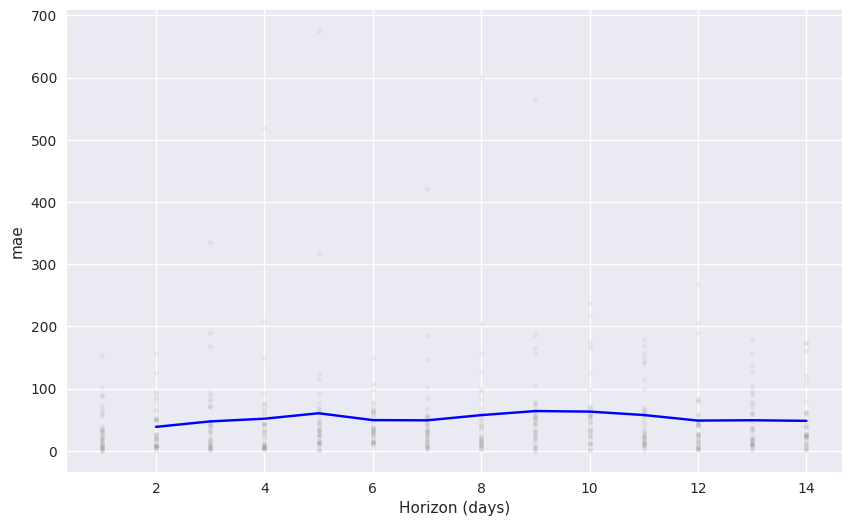

In [21]:

plot_cross_validation_metric(cv_results , metric='mae')
print(f"MAE médio da validação cruzada foi de {average_metrics['mae']:.2f}")

## Otimização de hiperparâmetros

### Criando experimento

Um experimento no MLflow é uma maneira de organizar e agrupar execuções de modelos de aprendizado de máquina. Cada experimento pode conter várias execuções, cada uma representando uma iteração diferente do modelo ou um conjunto diferente de hiperparâmetros. O MLflow Tracking permite que você registre informações sobre cada execução, como parâmetros, métricas e arquivos de saída, para que você possa comparar e avaliar diferentes execuções dentro de um experimento. Como no nosso projeto queremos otimizar os hiperparâmetros iremos gerar vários modelos, um experimento é perfeito para guardar isso.

Se não apontarmos definirmos lugar para os modelos eles serão salvos no ambiente padrão, ou experimento zero.

No nossa caso, logo abaixo vamos criar um experimento para nossa otimização de hiperparâmetros.


In [22]:
experiment_id = mlflow.create_experiment(
    "Forecast Otimização de hiperparâmetros",
    tags={"version": "v1", "priority": "P1"},
)
experimentOtimizacao = mlflow.get_experiment(experiment_id)
print("Name: {}".format(experimentOtimizacao.name))
print("Experiment_id: {}".format(experimentOtimizacao.experiment_id))
print("Artifact Location: {}".format(experimentOtimizacao.artifact_location))
print("Tags: {}".format(experimentOtimizacao.tags))
print("Lifecycle_stage: {}".format(experimentOtimizacao.lifecycle_stage))
print("Creation timestamp: {}".format(experimentOtimizacao.creation_time))

Name: Forecast Otimização de hiperparâmetros
Experiment_id: 1
Artifact Location: /ForecastSales/models/artifacts/1
Tags: {'version': 'v1', 'priority': 'P1'}
Lifecycle_stage: active
Creation timestamp: 1689537621750


### Treino de Otimização de hiperparâmetros
Na nossa otimização de hiperparâmetros está testanto 192 combinações deles também realizando validação cruzada da série temporal salvando tudo dentro do MLFlow

In [ ]:
param_grid = {'changepoint_range':[1,0.5,0.1,0.7],
                           'changepoint_prior_scale': [0.06,0.04,0.01],
                           'yearly_seasonality':[2,1,0,10],
                           'seasonality_prior_scale': [0.1,0.01,0.015,1]
              }

# Gera todas 192 combinações de hiperpametros
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

for i in range(len(all_params)):
    with mlflow.start_run(experiment_id=experimentOtimizacao.experiment_id,
                          run_name="Forecast_"+str(i)) as run:
        prophet_model = Prophet(weekly_seasonality = True, daily_seasonality=False , seasonality_mode ='additive', **all_params[i]).fit(train_prophet)  # Fit model with given params

        mlflow.log_params(extract_params(prophet_model))
        cv_results = cross_validation(
                                    prophet_model,
                                    initial = '56 days',
                                    period = '14 days' ,
                                    horizon = '14 days' )
            
        # Calcule as métricas de cv_results (validação cruzada), faz a média de cada métrica em todas as janelas de backtesting e registre no mlflow
        cv_metrics = ["mse", "rmse","mae","mape", "mdape","smape","coverage"]
        metrics_results = performance_metrics(cv_results, metrics=cv_metrics)
        average_metrics = metrics_results.loc[:, cv_metrics].mean(axis=0).to_dict()
        mlflow.log_metrics(average_metrics)
        model_info = mlflow.prophet.log_model(prophet_model, "prophet-model",conda_env=condaEnv)        
        future = prophet_model.make_future_dataframe(periods=len(teste_prophet),
                                    include_history=False)
        predictions = prophet_model.predict(future)
        
        ForecastPlotProphet(df_teste=teste_prophet,df_train=train_prophet,
                            df_predict_raw=predictions,HistorySlice=len(teste_prophet),
                            ShowFigs=False)
        
        testeMetrics = {'R2_score_teste': r2_score(teste_prophet['y'].values,predictions['yhat']),
        'MAE_teste': mean_absolute_error(teste_prophet['y'].values,predictions['yhat']),
        'MSE_teste': mean_squared_error(teste_prophet['y'].values,predictions['yhat']),
        'RMSE_teste': mean_squared_error(teste_prophet['y'].values,predictions['yhat'],squared=False)}
        mlflow.log_metrics(testeMetrics)
        plt.figure() 
        fig = prophet_model.plot_components(predictions)
        figPath =Path(Path.cwd()).parent.joinpath("images").joinpath("Components.png")
        fig.savefig(figPath, dpi=150)
        plt.close(fig)
        mlflow.log_artifact(figPath)
        mlflow.end_run()
        
#Isso durou uns 10 minutos 

## Avaliando modelos treinados na otimização
Consultando os resultados otimização de hiperparâmetros, verificamos que o modelo 47 foi o que teve as melhores métricas e a menor diferença entre treino e teste.

/tmp/ipykernel_633/780896497.py:40: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



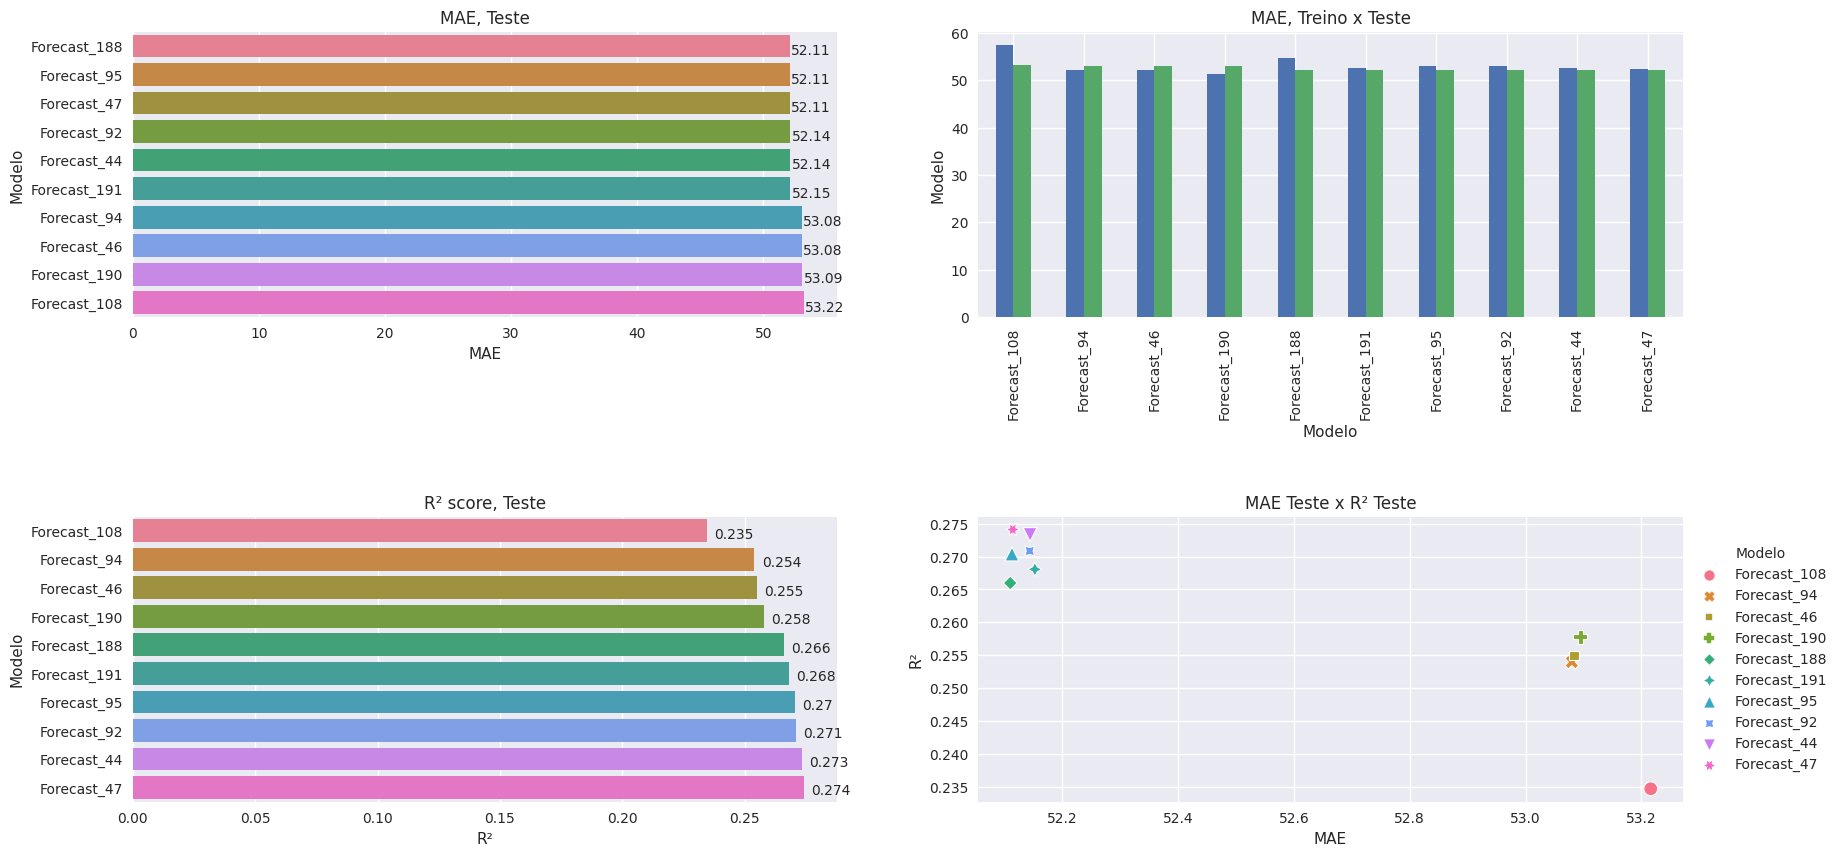

In [45]:

df_exp = pd.DataFrame(
            mlflow.search_runs(experiment_ids=experimentOtimizacao.experiment_id,
            run_view_type=mlflow.entities.ViewType.ACTIVE_ONLY)
            )

Top10_Models = df_exp[['run_id','tags.mlflow.runName','start_time',
                        'end_time','metrics.R2_score_teste','metrics.MAE_teste','metrics.mae',
                        'metrics.MSE_teste','metrics.mse','metrics.RMSE_teste', 'metrics.rmse',
                        'metrics.mdape', 'metrics.mape', 'metrics.coverage', 'metrics.smape',
                        'params.changepoint_range','params.seasonality_prior_scale',
                        'params.yearly_seasonality', 'params.daily_seasonality',
                        'params.weekly_seasonality', 'params.changepoint_prior_scale']].sort_values('metrics.MAE_teste').head(10)


fig, axs = plt.subplots(2,2,figsize=(20, 10))
fig.subplots_adjust(hspace=0.7)
dfGraf = Top10_Models.sort_values('metrics.R2_score_teste')

sns.barplot(data=dfGraf, y="tags.mlflow.runName",x="metrics.R2_score_teste",palette='husl',ax=axs[1,0])
axs[1,0].set(ylabel='Modelo', title='R² score, Teste',xlabel='R²')
for i, v in enumerate(dfGraf.sort_values('metrics.R2_score_teste')['metrics.R2_score_teste']):
 axs[1,0].text(v + 0.003, i + .25, str(round(v,3)))

sns.barplot(data=dfGraf.sort_values('metrics.MAE_teste'), y="tags.mlflow.runName",x="metrics.MAE_teste",palette='husl',ax=axs[0,0])
axs[0,0].set(ylabel='Modelo', title='MAE, Teste',xlabel='MAE')
for i, v in enumerate(dfGraf.sort_values('metrics.MAE_teste')['metrics.MAE_teste']):
 axs[0,0].text(v + 0.1, i + .3, str(round(v,2)))

 
 
dfGraf.plot(x='tags.mlflow.runName', y=['metrics.mae', 'metrics.MAE_teste'], kind='bar' , ax=axs[0,1],legend=False)
axs[0,1].set(ylabel='Modelo', title='MAE, Treino x Teste',xlabel='Modelo')

sns.scatterplot(data=dfGraf,x='metrics.MAE_teste',y='metrics.R2_score_teste',
                style='tags.mlflow.runName',s=100,
                ax=axs[1,1], hue='tags.mlflow.runName',
                legend="full",palette='husl')
axs[1,1].set(ylabel='R²', title='MAE Teste x R² Teste',xlabel='MAE')
axs[1,1].legend(title='Modelo', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
fig.show()

## Modelo selecionado

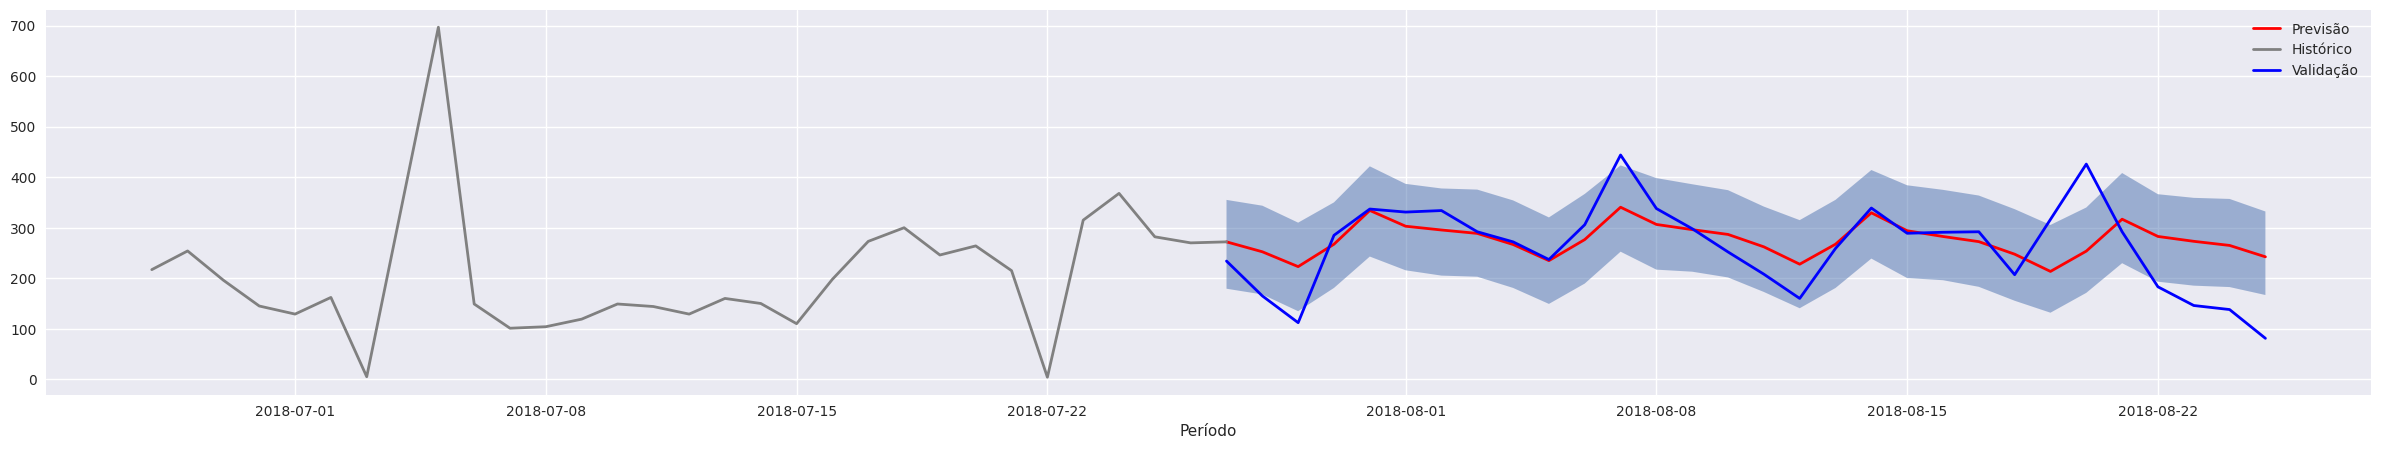

metrics.R2_score_teste  metrics.MAE_teste  metrics.mae  \
144                0.274127          52.114677     52.43245   

     metrics.MSE_teste  metrics.mse  metrics.RMSE_teste  metrics.rmse  \
144        5226.324255  7897.177652           72.293321     86.517408   

     metrics.mdape  metrics.mape  metrics.coverage  metrics.smape  
144       0.206969      0.665954          0.549402       0.281928

In [58]:
ModelName = "Forecast_47"

runId = str(Top10_Models[Top10_Models['tags.mlflow.runName']==ModelName]['run_id'].values[0])
logged_model_name = 'runs:/'+runId+'/prophet-model'


loaded_model = mlflow.prophet.load_model(logged_model_name)


futureView = loaded_model.make_future_dataframe(periods=len(teste_prophet),
                       include_history=False)



predict = loaded_model.predict(pd.DataFrame(futureView[:]))[['ds','yhat','yhat_lower','yhat_upper',]]

ForecastPlotProphet(df_teste=teste_prophet,df_train=train_prophet,
                df_predict_raw=predict,HistorySlice=len(teste_prophet),
                ShowFigs=True,SaveMLFlow=False)

Top10_Models[Top10_Models['tags.mlflow.runName']==ModelName][[item for item in Top10_Models.columns if "metrics" in item]]


# Modelo Final
Uma vez escolhido os hiperparâmetros ótimos é o momentos de criar um experimento de produção e treinar um modelos com todos os dados disponíveis para por em produção

In [39]:
# mlflow.set_tracking_uri('http://127.0.0.1:5000')

experiment_ForecastSalesProd = mlflow.create_experiment(
    "ForecastSalesProd",
    artifact_location=Path(Path.cwd()).parent.joinpath("models").joinpath("artifacts").as_uri(),
    tags={"version": "v1", "priority": "P1"},
)
experimentProd = mlflow.get_experiment(experiment_ForecastSalesProd)
print("Name: {}".format(experimentProd.name))
print("Experiment_id: {}".format(experimentProd.experiment_id))
print("Artifact Location: {}".format(experimentProd.artifact_location))
print("Tags: {}".format(experimentProd.tags))
print("Lifecycle_stage: {}".format(experimentProd.lifecycle_stage))
print("Creation timestamp: {}".format(experimentProd.creation_time))

Name: ForecastSalesProd
Experiment_id: 2
Artifact Location: file:///ForecastSales/models/artifacts
Tags: {'version': 'v1', 'priority': 'P1'}
Lifecycle_stage: active
Creation timestamp: 1689539460255


Nosso modelo tem os seguintes hiperparâmetros

In [40]:
ModelName = "Forecast_47"
runId = str(Top10_Models[Top10_Models['tags.mlflow.runName']==ModelName]['run_id'].values[0])
logged_model = 'runs:/'+runId+'/prophet-model'
BestModelParams = extract_params(mlflow.prophet.load_model(logged_model))
for i in ['specified_changepoints','y_scale','logistic_floor','country_holidays','component_modes']:
    BestModelParams.pop(i, None)
BestModelParams


{'growth': 'linear',
 'n_changepoints': 25,
 'changepoint_range': 1,
 'yearly_seasonality': 10,
 'weekly_seasonality': True,
 'daily_seasonality': False,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 1.0,
 'changepoint_prior_scale': 0.01,
 'holidays_prior_scale': 10.0,
 'mcmc_samples': 0,
 'interval_width': 0.8,
 'uncertainty_samples': 1000}

Criando o modelo de produção

17:31:04 - cmdstanpy - INFO - Chain [1] start processing
17:31:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/38 [00:00<?, ?it/s]

17:31:04 - cmdstanpy - INFO - Chain [1] start processing
17:31:04 - cmdstanpy - INFO - Chain [1] done processing
17:31:04 - cmdstanpy - INFO - Chain [1] start processing
17:31:05 - cmdstanpy - INFO - Chain [1] done processing
17:31:05 - cmdstanpy - INFO - Chain [1] start processing
17:31:05 - cmdstanpy - INFO - Chain [1] done processing
17:31:05 - cmdstanpy - INFO - Chain [1] start processing
17:31:05 - cmdstanpy - INFO - Chain [1] done processing
17:31:05 - cmdstanpy - INFO - Chain [1] start processing
17:31:05 - cmdstanpy - INFO - Chain [1] done processing
17:31:05 - cmdstanpy - INFO - Chain [1] start processing
17:31:05 - cmdstanpy - INFO - Chain [1] done processing
17:31:05 - cmdstanpy - INFO - Chain [1] start processing
17:31:05 - cmdstanpy - INFO - Chain [1] done processing
17:31:05 - cmdstanpy - INFO - Chain [1] start processing
17:31:05 - cmdstanpy - INFO - Chain [1] done processing
17:31:05 - cmdstanpy - INFO - Chain [1] start processing
17:31:05 - cmdstanpy - INFO - Chain [1]

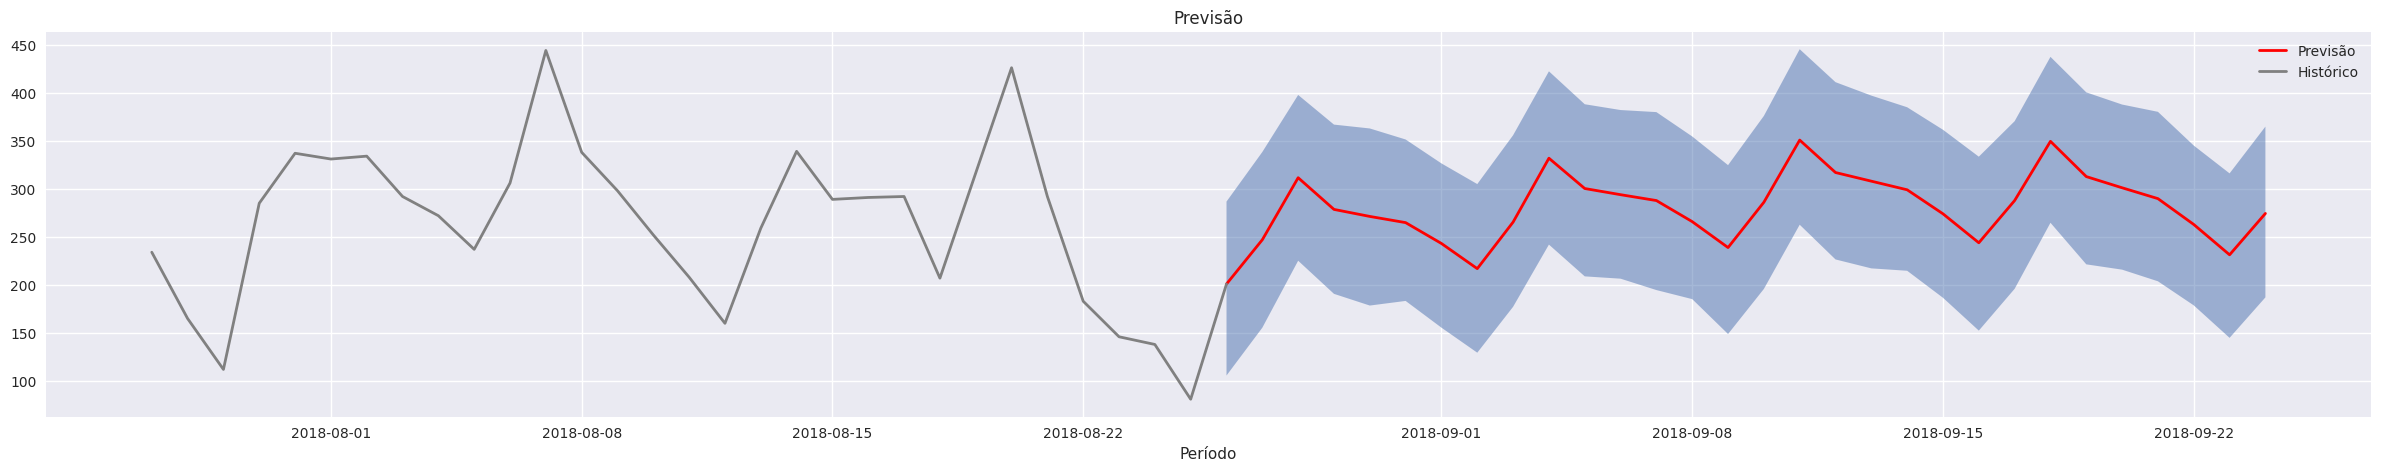

Métrica de Treino com Validação cruzada
{'mse': 8566.417111387822, 'rmse': 91.66015544960517, 'mae': 55.95205160483112, 'mape': 0.6759612154922645, 'mdape': 0.20611305356680612, 'smape': 0.30564566964781453, 'coverage': 0.551982277900848}


<Figure size 3000x500 with 0 Axes>

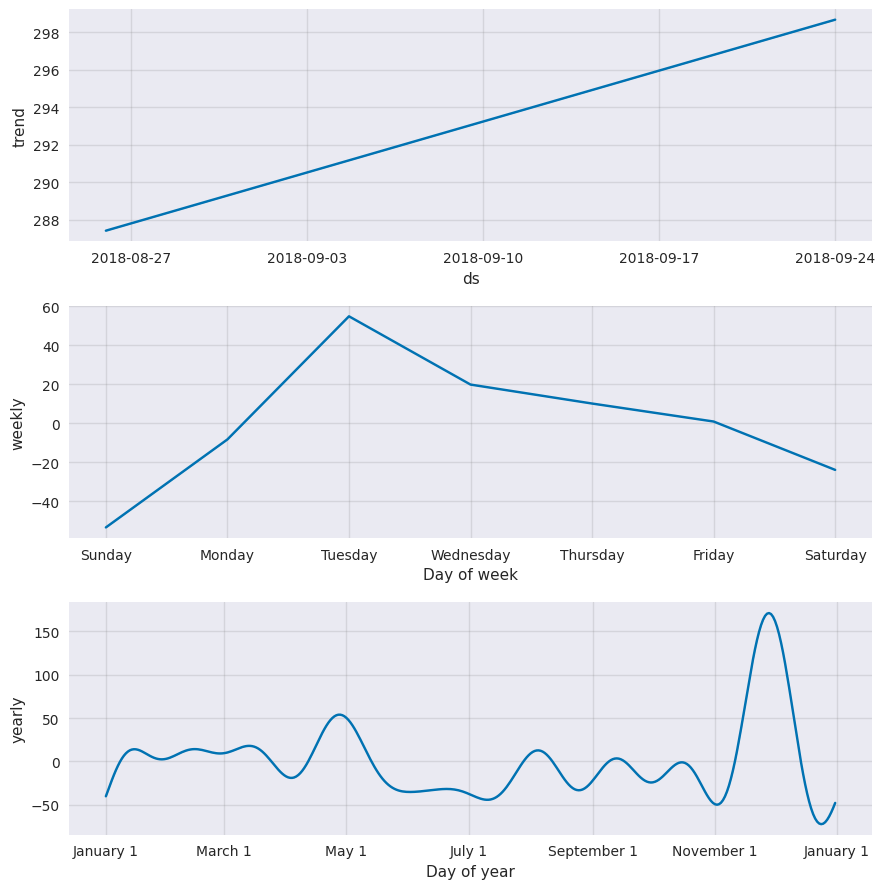

In [41]:

train_prophet_prod = orders_daily['Qt_Pedidos'].reset_index()
train_prophet_prod.columns = ['ds', 'y']

prophet_model = Prophet(**BestModelParams)

# with mlflow.start_run(run_name="prod_02",experiment_id="1",) as run:
with mlflow.start_run(run_name="prod_01",experiment_id=experimentProd.experiment_id,) as run:

    prophet_model.fit(train_prophet_prod)
    mlflow.log_params(extract_params(prophet_model))
    cv_results = cross_validation( prophet_model, initial = '56 days', period = '14 days', horizon = '14 days' )
    # Calculate metrics from cv_results, then average each metric across all backtesting windows and log to mlflow
    cv_metrics = ["mse", "rmse","mae","mape", "mdape","smape","coverage"]
    metrics_results = performance_metrics(cv_results, metrics=cv_metrics)
    average_metrics = metrics_results.loc[:, cv_metrics].mean(axis=0).to_dict()
    mlflow.log_metrics(average_metrics)
    model_info = mlflow.prophet.log_model(prophet_model, "prophet-model",conda_env=condaEnv)
    future = prophet_model.make_future_dataframe(periods=30,
                                 #freq='D',
                                 include_history=False)
    predictions = prophet_model.predict(future)

    ForecastPlotProphet(df_train=train_prophet_prod,df_predict_raw=predictions,HistorySlice=int(len(future)),title="Previsão")
    print("Métrica de Treino com Validação cruzada")
    print(average_metrics)
    plt.figure()  
    fig = prophet_model.plot_components(predictions)
    figPath =Path(Path.cwd()).parent.joinpath("images").joinpath("Components.png")
    fig.savefig(figPath, dpi=150)
    # plt.close(fig)
    mlflow.log_artifact(figPath)
    mlflow.end_run()
# Load saved model
# prophet_model_saved = mlflow.pyfunc.load_model(model_info.model_uri)
# predictions = prophet_model_saved.predict(future)

# Registrando o modelo

In [42]:


client = MlflowClient()
client.create_registered_model("SalesModel")

<RegisteredModel: aliases={}, creation_timestamp=1689539499490, description='', last_updated_timestamp=1689539499490, latest_versions=[], name='SalesModel', tags={}>

In [59]:
df_prod = pd.DataFrame(
            mlflow.search_runs(experiment_ids=experimentProd.experiment_id,
                               run_view_type=mlflow.entities.ViewType.ACTIVE_ONLY,
                               filter_string="attributes.run_name = 'prod_01'"
                               )
            )
runId = str(df_prod['run_id'].values[0])
runId

'92c0034eef2547289d5e15c9dc5bdf1c'

In [60]:
# client = MlflowClient()
result = client.create_model_version(
    name="SalesModel",
    source="file:///ForecastSales/models/artifacts/"+runId+"/artifacts/prophet-model",
    run_id=runId,
)

client.transition_model_version_stage(
    name="SalesModel", version=1, stage="Production"
)

2023/07/16 17:43:00 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: SalesModel, version 1


<ModelVersion: aliases=[], creation_timestamp=1689540180265, current_stage='Production', description='', last_updated_timestamp=1689540180286, name='SalesModel', run_id='92c0034eef2547289d5e15c9dc5bdf1c', run_link='', source='file:///ForecastSales/models/artifacts/92c0034eef2547289d5e15c9dc5bdf1c/artifacts/prophet-model', status='READY', status_message='', tags={}, user_id='', version='1'>

# Request API
É preciso preparar o ambiente para criar ambientes virtuais para que ele possa servir o modelo neles. Para isso no terminal execute os seguintes comandos que instalaram o pyenv como ambiente de python virtual.

>```bash
>cd /
>git clone https://github.com/pyenv/pyenv.git ~/.pyenv
>export PYENV_ROOT="$HOME/.pyenv"
>export PATH="$PYENV_ROOT/bin:$PATH"
>export PATH="$HOME/.pyenv/bin:$PATH"
>eval "$(pyenv init --path)"
>exec "$SHELL"
>```

Em um novo terminal do WLS execute os seguintes comandos para postar o modelo como uma API, isso vai travar o terminal e gerar um link de acesso a API do modelo. Repare que a porta da API tem que ser diferente do modelo.

>```bash
>cd /ForecastSales/models
>export MLFLOW_TRACKING_URI=http://127.0.0.1:5000
>mlflow models serve -m 'models:/SalesModel/Production' -p 5001
>```



In [61]:
url = "http://127.0.0.1:5001/invocations"
headers = {"Content-Type": "application/json"}
data = {
    "dataframe_split": {
        "columns": ["ds"],
        "data": [["2018-08-27"],["2018-08-28"]]
    }
}
response = requests.post(url, data=json.dumps(data), headers=headers)

# print(response.text)

data = json.loads(response.text)
df_predict = pd.DataFrame(data['predictions'])
df_predict

ds       trend  yhat_lower  yhat_upper  trend_lower  \
0  2018-08-27T00:00:00  287.799947  161.849255  338.638439   287.799947   
1  2018-08-28T00:00:00  288.188019  223.633015  399.682025   288.188019   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0   287.799947      -40.806141            -40.806141            -40.806141   
1   288.188019       23.352212             23.352212             23.352212   

      weekly  weekly_lower  weekly_upper     yearly  yearly_lower  \
0  -8.280201     -8.280201     -8.280201 -32.525940    -32.525940   
1  54.752035     54.752035     54.752035 -31.399823    -31.399823   

   yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0    -32.525940                   0.0                         0.0   
1    -31.399823                   0.0                         0.0   

   multiplicative_terms_upper        yhat  
0                         0.0  246.993806  
1                         0.0  311.540231

# Pronto, seu modelo está em pseudo-produção.

<img src="https://media.tenor.com/7KE3TH-N4IAAAAAd/celebrate-party.gif" width="350" height="250">\